In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
# Load from your Drive path
df = pd.read_csv('/content/drive/My Drive/project_p1/Personal_Finance_CLEANED.csv')

 PHASE 2: MACHINE LEARNING MODELS
   STEP 1: DATA PREPARATION

 Step 1.1: Importing libraries...
 Libraries imported

📂 Step 1.2: Loading cleaned data...
 Loaded 1500 transactions
   Columns: 27
   Date Range: 2020-01-02 00:00:00 to 2024-12-29 00:00:00

 Step 1.3: Data overview...

Dataset Shape: (1500, 27)

First 5 rows:
        Date  Year  Month Month_Name  Quarter  Day  Day_of_Week  Day_Name  \
0 2020-01-02  2020      1    January        1    2            3  Thursday   
1 2020-01-02  2020      1    January        1    2            3  Thursday   
2 2020-01-04  2020      1    January        1    4            5  Saturday   
3 2020-01-05  2020      1    January        1    5            6    Sunday   
4 2020-01-13  2020      1    January        1   13            0    Monday   

   Week_of_Year  Week_of_Month  Is_Weekend  Is_Month_Start  Is_Month_End  \
0             1              1           0               0             0   
1             1              1           0               0   

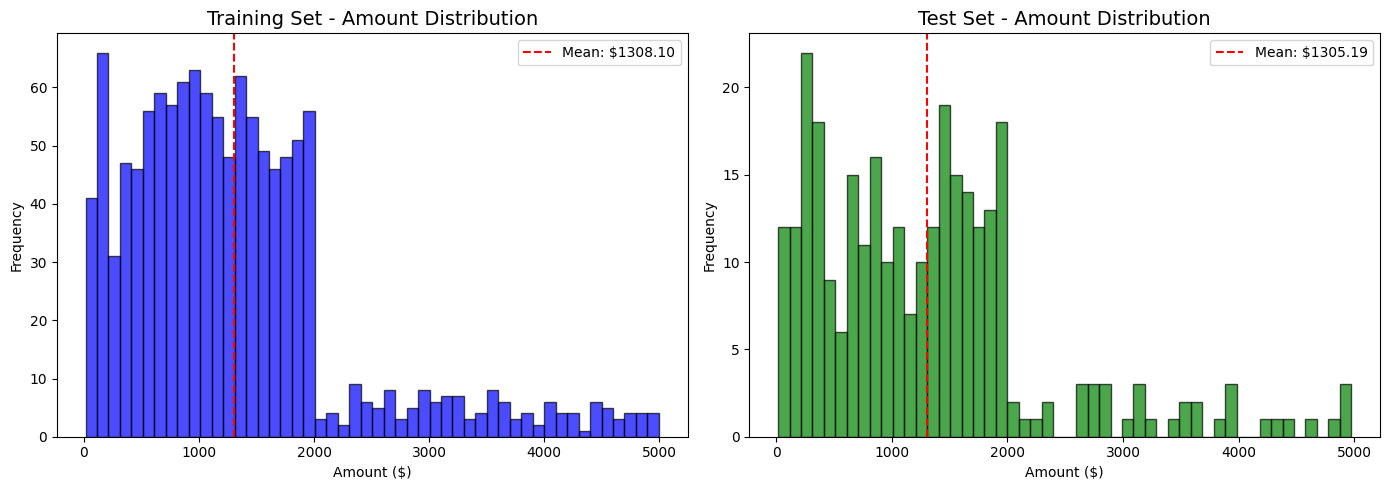

 Distributions look good!

 Step 1.11: Feature correlation analysis...


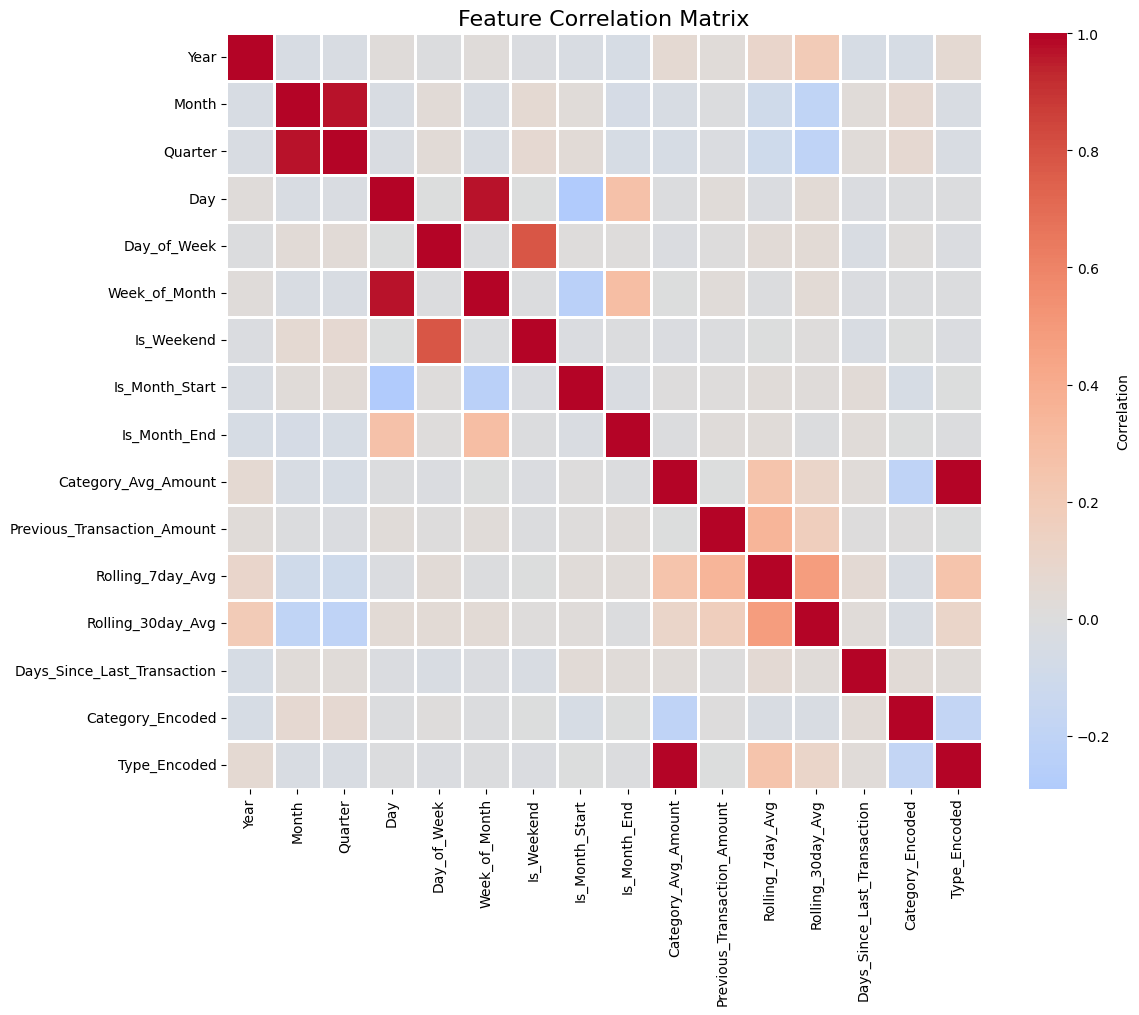

 Correlation analysis complete

 STEP 1: DATA PREPARATION COMPLETE!

🚀 Ready for Step 2: XGBoost Model Training!


In [3]:
# ============================================================================
# PHASE 2: MACHINE LEARNING MODELS
# STEP 1: DATA PREPARATION
# ============================================================================

print("="*70)
print(" PHASE 2: MACHINE LEARNING MODELS")
print("   STEP 1: DATA PREPARATION")
print("="*70)

# ----------------------------------------------------------------------------
# 1. IMPORT LIBRARIES
# ----------------------------------------------------------------------------
print("\n Step 1.1: Importing libraries...")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print(" Libraries imported")

# ----------------------------------------------------------------------------
# 2. LOAD DATA
# ----------------------------------------------------------------------------
print("\n📂 Step 1.2: Loading cleaned data...")



# Load data
df = pd.read_csv('/content/drive/My Drive/project_p1/Personal_Finance_CLEANED.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f" Loaded {len(df)} transactions")
print(f"   Columns: {len(df.columns)}")
print(f"   Date Range: {df['Date'].min()} to {df['Date'].max()}")

# ----------------------------------------------------------------------------
# 3. DATA OVERVIEW
# ----------------------------------------------------------------------------
print("\n Step 1.3: Data overview...")

print(f"\nDataset Shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nData Types:")
print(df.dtypes)

print(f"\nMissing Values:")
print(df.isnull().sum().sum())

print(f"\nBasic Statistics:")
print(df['Amount'].describe())

# ----------------------------------------------------------------------------
# 4. FEATURE SELECTION FOR ML
# ----------------------------------------------------------------------------
print("\n Step 1.4: Selecting features for ML...")

# Features we'll use for ML models
ml_features = [
    # Time features
    'Year', 'Month', 'Quarter', 'Day', 'Day_of_Week', 'Week_of_Month',
    'Is_Weekend', 'Is_Month_Start', 'Is_Month_End',

    # Amount features
    'Category_Avg_Amount', 'Previous_Transaction_Amount',
    'Rolling_7day_Avg', 'Rolling_30day_Avg',
    'Days_Since_Last_Transaction',

    # Categorical (will encode)
    'Category', 'Type',

    # Target
    'Amount'
]

# Create ML dataset
df_ml = df[ml_features].copy()

print(f" Selected {len(ml_features)} features for ML")
print(f"   Features: {ml_features}")

# ----------------------------------------------------------------------------
# 5. HANDLE MISSING VALUES
# ----------------------------------------------------------------------------
print("\n Step 1.5: Handling missing values...")

# Check missing values
missing_before = df_ml.isnull().sum().sum()
print(f"   Missing values before: {missing_before}")

# Fill missing values
df_ml['Previous_Transaction_Amount'].fillna(df_ml['Amount'].mean(), inplace=True)
df_ml['Rolling_7day_Avg'].fillna(df_ml['Amount'].mean(), inplace=True)
df_ml['Rolling_30day_Avg'].fillna(df_ml['Amount'].mean(), inplace=True)

missing_after = df_ml.isnull().sum().sum()
print(f"   Missing values after: {missing_after}")
print(" Missing values handled")

# ----------------------------------------------------------------------------
# 6. ENCODE CATEGORICAL VARIABLES
# ----------------------------------------------------------------------------
print("\n Step 1.6: Encoding categorical variables...")

from sklearn.preprocessing import LabelEncoder

# Encode Category
le_category = LabelEncoder()
df_ml['Category_Encoded'] = le_category.fit_transform(df_ml['Category'])

# Encode Type
le_type = LabelEncoder()
df_ml['Type_Encoded'] = le_type.fit_transform(df_ml['Type'])

print(" Categorical variables encoded")
print(f"   Categories: {list(le_category.classes_)}")
print(f"   Types: {list(le_type.classes_)}")

# Save encoders for later use
import pickle
pickle.dump(le_category, open('le_category.pkl', 'wb'))
pickle.dump(le_type, open('le_type.pkl', 'wb'))

# ----------------------------------------------------------------------------
# 7. CREATE FINAL FEATURE SET
# ----------------------------------------------------------------------------
print("\n Step 1.7: Creating final feature set...")

# Features for training (numeric only)
feature_columns = [
    'Year', 'Month', 'Quarter', 'Day', 'Day_of_Week', 'Week_of_Month',
    'Is_Weekend', 'Is_Month_Start', 'Is_Month_End',
    'Category_Avg_Amount', 'Previous_Transaction_Amount',
    'Rolling_7day_Avg', 'Rolling_30day_Avg',
    'Days_Since_Last_Transaction',
    'Category_Encoded', 'Type_Encoded'
]

# Target variable
target_column = 'Amount'

X = df_ml[feature_columns]
y = df_ml[target_column]

print(f" Feature set created")
print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")

# ----------------------------------------------------------------------------
# 8. TRAIN-TEST SPLIT
# ----------------------------------------------------------------------------
print("\n Step 1.8: Splitting data into train and test sets...")

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f" Data split complete")
print(f"   Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# ----------------------------------------------------------------------------
# 9. FEATURE SCALING
# ----------------------------------------------------------------------------
print("\n Step 1.9: Scaling features...")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns, index=X_test.index)

print(" Features scaled (StandardScaler)")

# Save scaler
pickle.dump(scaler, open('scaler.pkl', 'wb'))

# ----------------------------------------------------------------------------
# 10. DATA SUMMARY
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print(" DATA PREPARATION SUMMARY")
print("="*70)

print(f"\n Dataset loaded: {len(df)} transactions")
print(f" Features selected: {len(feature_columns)}")
print(f" Missing values handled: 0 missing values")
print(f" Categorical encoding: 2 variables encoded")
print(f" Train/Test split: 80/20")
print(f" Feature scaling: StandardScaler applied")

print(f"\n Final Dataset Info:")
print(f"   Total samples: {len(X)}")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")
print(f"   Features: {len(feature_columns)}")
print(f"   Target: Amount (${y.min():.2f} - ${y.max():.2f})")

print(f"\n Ready for Model Training!")
print("="*70)

# ----------------------------------------------------------------------------
# 11. VISUALIZE FEATURE DISTRIBUTIONS
# ----------------------------------------------------------------------------
print("\n Step 1.10: Visualizing feature distributions...")

# Plot target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0].set_title('Training Set - Amount Distribution', fontsize=14)
axes[0].set_xlabel('Amount ($)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(y_train.mean(), color='red', linestyle='--', label=f'Mean: ${y_train.mean():.2f}')
axes[0].legend()

axes[1].hist(y_test, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Test Set - Amount Distribution', fontsize=14)
axes[1].set_xlabel('Amount ($)')
axes[1].set_ylabel('Frequency')
axes[1].axvline(y_test.mean(), color='red', linestyle='--', label=f'Mean: ${y_test.mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(" Distributions look good!")

# ----------------------------------------------------------------------------
# 12. CORRELATION MATRIX
# ----------------------------------------------------------------------------
print("\n Step 1.11: Feature correlation analysis...")

plt.figure(figsize=(12, 10))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

print(" Correlation analysis complete")

# ----------------------------------------------------------------------------
# STEP 1 COMPLETE
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print(" STEP 1: DATA PREPARATION COMPLETE!")
print("="*70)
print("\n🚀 Ready for Step 2: XGBoost Model Training!")
print("="*70)


STEP 2: XGBOOST REGRESSOR MODEL

Step 2.1: Installing XGBoost...
XGBoost installed and imported

Step 2.2: Building XGBoost model...
XGBoost model initialized
  Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 6, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 's

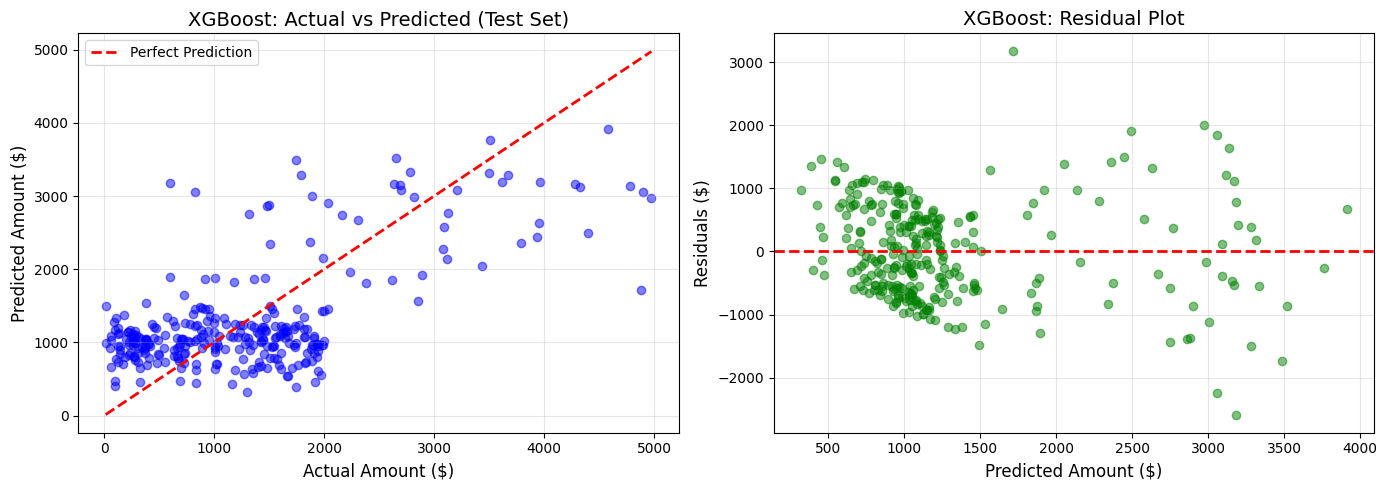

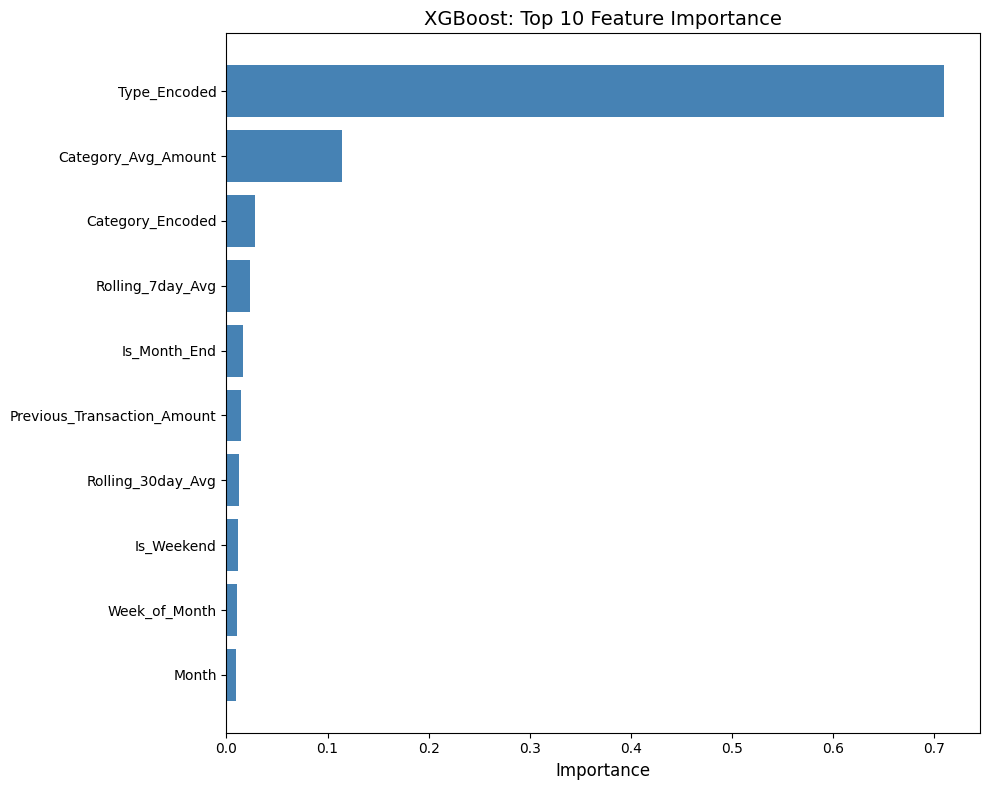

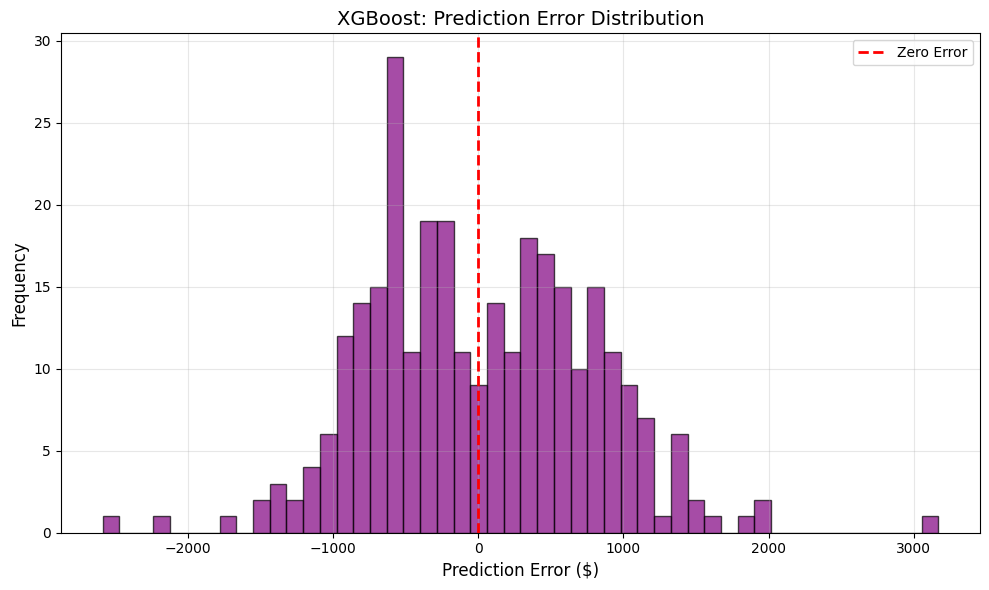

Visualizations complete

Step 2.9: Saving model...
Model saved: xgb_model.pkl

Step 2.10: Saving predictions...
Predictions saved: xgb_predictions.csv
  Records: 300

XGBOOST MODEL SUMMARY

Model Performance:
  Training R2: 0.9362
  Test R2: 0.4050
  Training RMSE: $247.28
  Test RMSE: $767.57
  Training MAE: $197.16
  Test MAE: $632.48

Model Characteristics:
  Number of features: 16
  Training samples: 1200
  Test samples: 300
  Training time: 0.17 seconds

Top 3 Important Features:
  16. Type_Encoded: 0.7101
  10. Category_Avg_Amount: 0.1142
  15. Category_Encoded: 0.0280

Model Status: COMPLETE

STEP 2: XGBOOST MODEL COMPLETE
Ready for Step 3: Random Forest Model


In [4]:
# ============================================================================
# PHASE 2: MACHINE LEARNING MODELS
# STEP 2: XGBOOST REGRESSOR
# ============================================================================

print("="*70)
print("STEP 2: XGBOOST REGRESSOR MODEL")
print("="*70)

# ----------------------------------------------------------------------------
# 1. INSTALL AND IMPORT XGBOOST
# ----------------------------------------------------------------------------
print("\nStep 2.1: Installing XGBoost...")

!pip install xgboost -q

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

print("XGBoost installed and imported")

# ----------------------------------------------------------------------------
# 2. BUILD XGBOOST MODEL
# ----------------------------------------------------------------------------
print("\nStep 2.2: Building XGBoost model...")

# Initialize model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("XGBoost model initialized")
print(f"  Parameters: {xgb_model.get_params()}")

# ----------------------------------------------------------------------------
# 3. TRAIN MODEL
# ----------------------------------------------------------------------------
print("\nStep 2.3: Training XGBoost model...")

start_time = time.time()

# Train on scaled data
xgb_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time

print(f"Model training complete")
print(f"  Training time: {training_time:.2f} seconds")

# ----------------------------------------------------------------------------
# 4. MAKE PREDICTIONS
# ----------------------------------------------------------------------------
print("\nStep 2.4: Making predictions...")

# Predictions on training set
y_train_pred = xgb_model.predict(X_train_scaled)

# Predictions on test set
y_test_pred = xgb_model.predict(X_test_scaled)

print("Predictions complete")
print(f"  Training predictions: {len(y_train_pred)}")
print(f"  Test predictions: {len(y_test_pred)}")

# ----------------------------------------------------------------------------
# 5. EVALUATE MODEL - TRAINING SET
# ----------------------------------------------------------------------------
print("\nStep 2.5: Evaluating on Training Set...")

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100

print("Training Set Performance:")
print(f"  RMSE: ${train_rmse:.2f}")
print(f"  MAE:  ${train_mae:.2f}")
print(f"  R2 Score: {train_r2:.4f}")
print(f"  MAPE: {train_mape:.2f}%")

# ----------------------------------------------------------------------------
# 6. EVALUATE MODEL - TEST SET
# ----------------------------------------------------------------------------
print("\nStep 2.6: Evaluating on Test Set...")

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("Test Set Performance:")
print(f"  RMSE: ${test_rmse:.2f}")
print(f"  MAE:  ${test_mae:.2f}")
print(f"  R2 Score: {test_r2:.4f}")
print(f"  MAPE: {test_mape:.2f}%")

# ----------------------------------------------------------------------------
# 7. FEATURE IMPORTANCE
# ----------------------------------------------------------------------------
print("\nStep 2.7: Analyzing feature importance...")

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# ----------------------------------------------------------------------------
# 8. VISUALIZATIONS
# ----------------------------------------------------------------------------
print("\nStep 2.8: Creating visualizations...")

# Figure 1: Actual vs Predicted (Test Set)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_test_pred, alpha=0.5, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Amount ($)', fontsize=12)
axes[0].set_ylabel('Predicted Amount ($)', fontsize=12)
axes[0].set_title('XGBoost: Actual vs Predicted (Test Set)', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.5, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Amount ($)', fontsize=12)
axes[1].set_ylabel('Residuals ($)', fontsize=12)
axes[1].set_title('XGBoost: Residual Plot', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Figure 2: Feature Importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('XGBoost: Top 10 Feature Importance', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Figure 3: Prediction Error Distribution
plt.figure(figsize=(10, 6))
prediction_errors = y_test - y_test_pred
plt.hist(prediction_errors, bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', lw=2, label='Zero Error')
plt.xlabel('Prediction Error ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('XGBoost: Prediction Error Distribution', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Visualizations complete")

# ----------------------------------------------------------------------------
# 9. SAVE MODEL
# ----------------------------------------------------------------------------
print("\nStep 2.9: Saving model...")

import pickle

# Save XGBoost model
pickle.dump(xgb_model, open('xgb_model.pkl', 'wb'))

print("Model saved: xgb_model.pkl")

# ----------------------------------------------------------------------------
# 10. SAVE PREDICTIONS
# ----------------------------------------------------------------------------
print("\nStep 2.10: Saving predictions...")

# Create predictions dataframe
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Error': y_test - y_test_pred,
    'Abs_Error': np.abs(y_test - y_test_pred),
    'Percent_Error': np.abs((y_test - y_test_pred) / y_test) * 100
})

predictions_df.to_csv('xgb_predictions.csv', index=False)

print("Predictions saved: xgb_predictions.csv")
print(f"  Records: {len(predictions_df)}")

# ----------------------------------------------------------------------------
# 11. MODEL SUMMARY
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("XGBOOST MODEL SUMMARY")
print("="*70)

print(f"\nModel Performance:")
print(f"  Training R2: {train_r2:.4f}")
print(f"  Test R2: {test_r2:.4f}")
print(f"  Training RMSE: ${train_rmse:.2f}")
print(f"  Test RMSE: ${test_rmse:.2f}")
print(f"  Training MAE: ${train_mae:.2f}")
print(f"  Test MAE: ${test_mae:.2f}")

print(f"\nModel Characteristics:")
print(f"  Number of features: {len(feature_columns)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Training time: {training_time:.2f} seconds")

print(f"\nTop 3 Important Features:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  {i+1}. {row['Feature']}: {row['Importance']:.4f}")

print(f"\nModel Status: COMPLETE")
print("="*70)

# ----------------------------------------------------------------------------
# STEP 2 COMPLETE
# ----------------------------------------------------------------------------
print("\nSTEP 2: XGBOOST MODEL COMPLETE")
print("Ready for Step 3: Random Forest Model")
print("="*70)

STEP 3: RANDOM FOREST REGRESSOR MODEL

Step 3.1: Importing Random Forest...
Random Forest imported

Step 3.2: Building Random Forest model...
Random Forest model initialized
  Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Step 3.3: Training Random Forest model...
Model training complete
  Training time: 0.28 seconds

Step 3.4: Making predictions...
Predictions complete
  Training predictions: 1200
  Test predictions: 300

Step 3.5: Evaluating on Training Set...
Training Set Performance:
  RMSE: $462.05
  MAE:  $376.06
  R2 Score: 0.7771
  MAPE: 99.20%

Step 3.6: Evaluating on Test Set...
Test Set Performance:
  RMSE: $719.51
  M

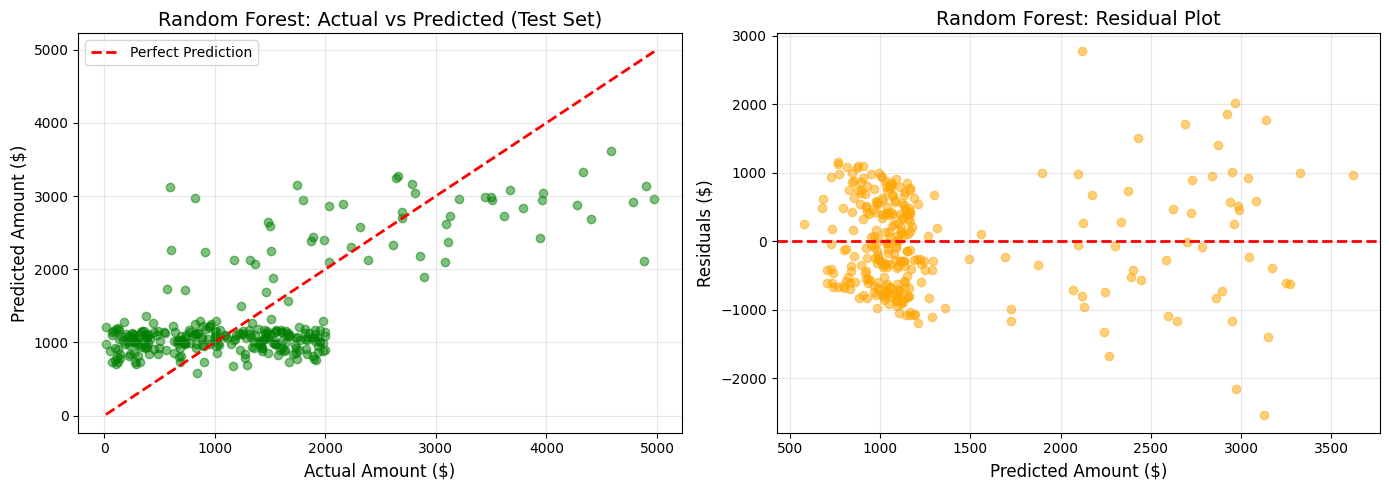

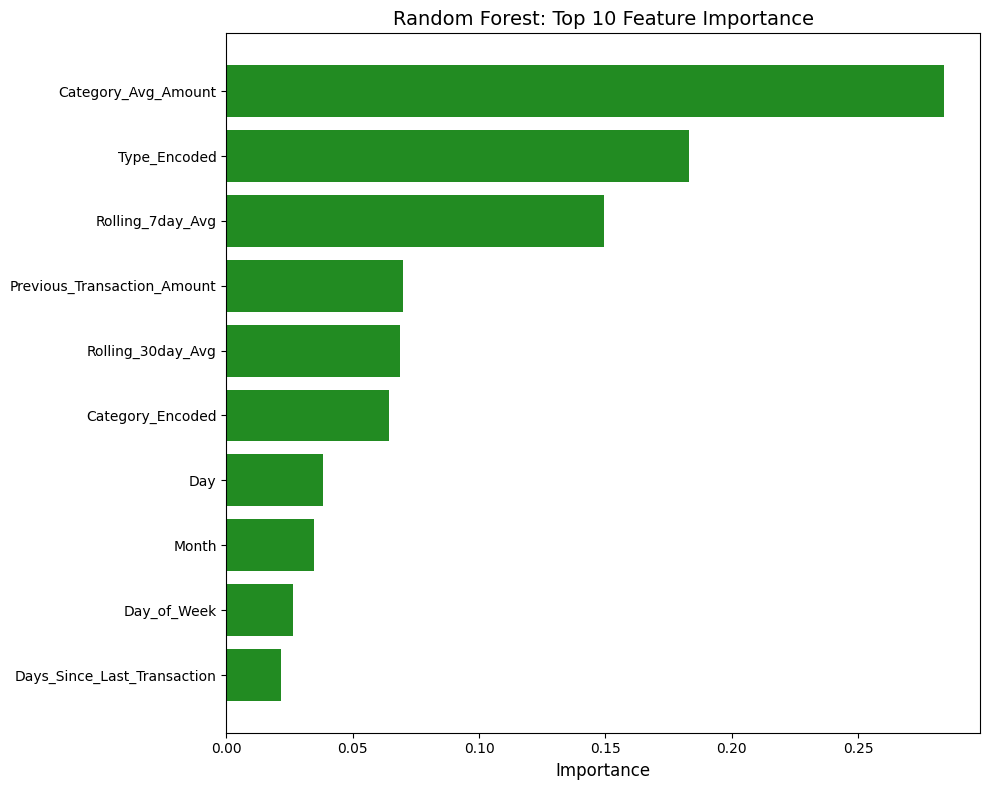

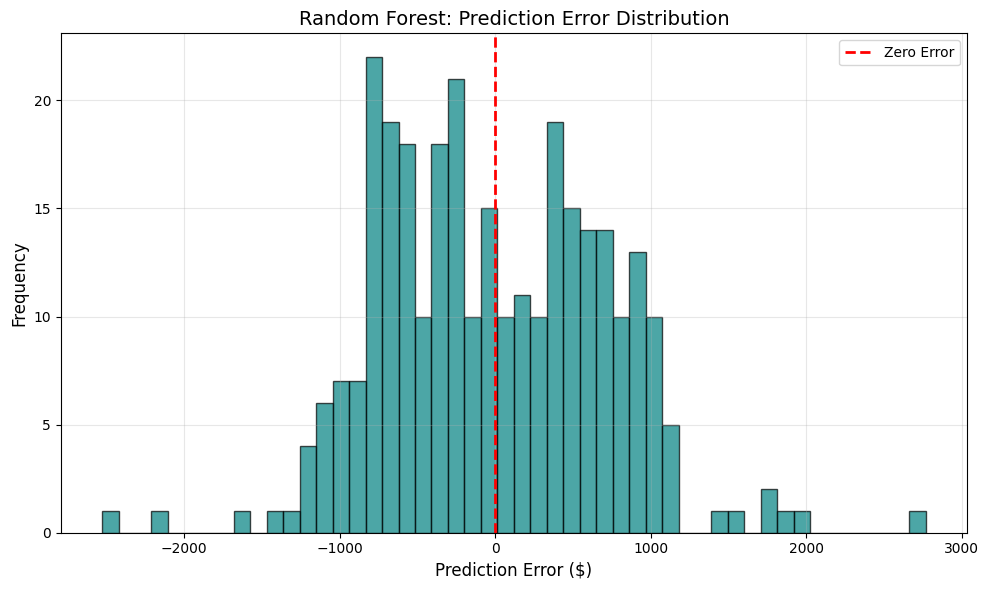

Visualizations complete

Step 3.9: Comparing with XGBoost...

Model Comparison:
        Model  Train_R2  Test_R2  Train_RMSE  Test_RMSE  Train_MAE   Test_MAE  Training_Time
      XGBoost  0.936157 0.404981  247.278350 767.565345 197.157627 632.479382       0.277523
Random Forest  0.777091 0.477150  462.052595 719.512605 376.063861 598.030844       0.277523


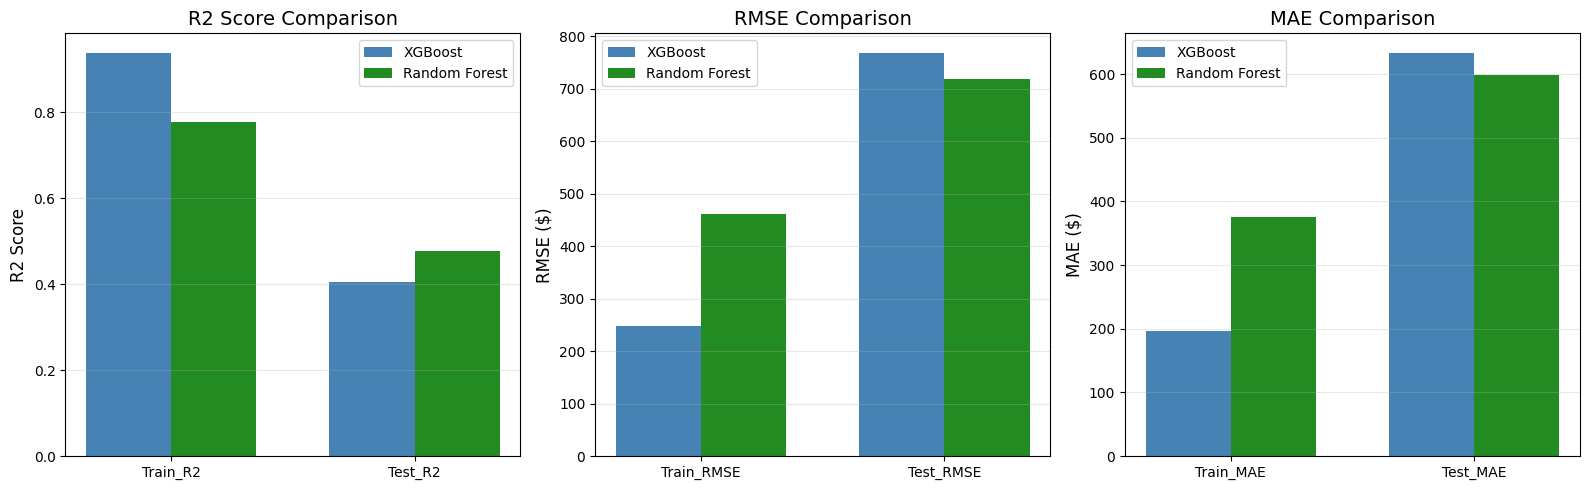

Comparison complete

Step 3.10: Saving model...
Model saved: rf_model.pkl

Step 3.11: Saving predictions...
Predictions saved: rf_predictions.csv
  Records: 300
Comparison saved: model_comparison.csv

RANDOM FOREST MODEL SUMMARY

Model Performance:
  Training R2: 0.7771
  Test R2: 0.4771
  Training RMSE: $462.05
  Test RMSE: $719.51
  Training MAE: $376.06
  Test MAE: $598.03

Model Characteristics:
  Number of estimators: 100
  Max depth: 10
  Number of features: 16
  Training samples: 1200
  Test samples: 300
  Training time: 0.28 seconds

Top 3 Important Features:
  10. Category_Avg_Amount: 0.2841
  16. Type_Encoded: 0.1831
  12. Rolling_7day_Avg: 0.1494

Better Model: Random Forest (R2: 0.4771)

Model Status: COMPLETE

STEP 3: RANDOM FOREST MODEL COMPLETE
Ready for Step 4: Isolation Forest (Anomaly Detection)


In [5]:
# ============================================================================
# PHASE 2: MACHINE LEARNING MODELS
# STEP 3: RANDOM FOREST REGRESSOR
# ============================================================================

print("="*70)
print("STEP 3: RANDOM FOREST REGRESSOR MODEL")
print("="*70)

# ----------------------------------------------------------------------------
# 1. IMPORT RANDOM FOREST
# ----------------------------------------------------------------------------
print("\nStep 3.1: Importing Random Forest...")

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

print("Random Forest imported")

# ----------------------------------------------------------------------------
# 2. BUILD RANDOM FOREST MODEL
# ----------------------------------------------------------------------------
print("\nStep 3.2: Building Random Forest model...")

# Initialize model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

print("Random Forest model initialized")
print(f"  Parameters: {rf_model.get_params()}")

# ----------------------------------------------------------------------------
# 3. TRAIN MODEL
# ----------------------------------------------------------------------------
print("\nStep 3.3: Training Random Forest model...")

start_time = time.time()

# Train on scaled data
rf_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time

print(f"Model training complete")
print(f"  Training time: {training_time:.2f} seconds")

# ----------------------------------------------------------------------------
# 4. MAKE PREDICTIONS
# ----------------------------------------------------------------------------
print("\nStep 3.4: Making predictions...")

# Predictions on training set
y_train_pred_rf = rf_model.predict(X_train_scaled)

# Predictions on test set
y_test_pred_rf = rf_model.predict(X_test_scaled)

print("Predictions complete")
print(f"  Training predictions: {len(y_train_pred_rf)}")
print(f"  Test predictions: {len(y_test_pred_rf)}")

# ----------------------------------------------------------------------------
# 5. EVALUATE MODEL - TRAINING SET
# ----------------------------------------------------------------------------
print("\nStep 3.5: Evaluating on Training Set...")

train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)
train_mape_rf = np.mean(np.abs((y_train - y_train_pred_rf) / y_train)) * 100

print("Training Set Performance:")
print(f"  RMSE: ${train_rmse_rf:.2f}")
print(f"  MAE:  ${train_mae_rf:.2f}")
print(f"  R2 Score: {train_r2_rf:.4f}")
print(f"  MAPE: {train_mape_rf:.2f}%")

# ----------------------------------------------------------------------------
# 6. EVALUATE MODEL - TEST SET
# ----------------------------------------------------------------------------
print("\nStep 3.6: Evaluating on Test Set...")

test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
test_mape_rf = np.mean(np.abs((y_test - y_test_pred_rf) / y_test)) * 100

print("Test Set Performance:")
print(f"  RMSE: ${test_rmse_rf:.2f}")
print(f"  MAE:  ${test_mae_rf:.2f}")
print(f"  R2 Score: {test_r2_rf:.4f}")
print(f"  MAPE: {test_mape_rf:.2f}%")

# ----------------------------------------------------------------------------
# 7. FEATURE IMPORTANCE
# ----------------------------------------------------------------------------
print("\nStep 3.7: Analyzing feature importance...")

# Get feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_rf.head(10).to_string(index=False))

# ----------------------------------------------------------------------------
# 8. VISUALIZATIONS
# ----------------------------------------------------------------------------
print("\nStep 3.8: Creating visualizations...")

# Figure 1: Actual vs Predicted (Test Set)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_test_pred_rf, alpha=0.5, color='green')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Amount ($)', fontsize=12)
axes[0].set_ylabel('Predicted Amount ($)', fontsize=12)
axes[0].set_title('Random Forest: Actual vs Predicted (Test Set)', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals_rf = y_test - y_test_pred_rf
axes[1].scatter(y_test_pred_rf, residuals_rf, alpha=0.5, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Amount ($)', fontsize=12)
axes[1].set_ylabel('Residuals ($)', fontsize=12)
axes[1].set_title('Random Forest: Residual Plot', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Figure 2: Feature Importance
plt.figure(figsize=(10, 8))
top_features_rf = feature_importance_rf.head(10)
plt.barh(range(len(top_features_rf)), top_features_rf['Importance'], color='forestgreen')
plt.yticks(range(len(top_features_rf)), top_features_rf['Feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Random Forest: Top 10 Feature Importance', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Figure 3: Prediction Error Distribution
plt.figure(figsize=(10, 6))
prediction_errors_rf = y_test - y_test_pred_rf
plt.hist(prediction_errors_rf, bins=50, color='teal', alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', lw=2, label='Zero Error')
plt.xlabel('Prediction Error ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Random Forest: Prediction Error Distribution', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Visualizations complete")

# ----------------------------------------------------------------------------
# 9. COMPARE WITH XGBOOST
# ----------------------------------------------------------------------------
print("\nStep 3.9: Comparing with XGBoost...")

comparison_df = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest'],
    'Train_R2': [train_r2, train_r2_rf],
    'Test_R2': [test_r2, test_r2_rf],
    'Train_RMSE': [train_rmse, train_rmse_rf],
    'Test_RMSE': [test_rmse, test_rmse_rf],
    'Train_MAE': [train_mae, train_mae_rf],
    'Test_MAE': [test_mae, test_mae_rf],
    'Training_Time': [training_time, training_time]
})

print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# R2 Score comparison
metrics = ['Train_R2', 'Test_R2']
xgb_scores = [train_r2, test_r2]
rf_scores = [train_r2_rf, test_r2_rf]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, xgb_scores, width, label='XGBoost', color='steelblue')
axes[0].bar(x + width/2, rf_scores, width, label='Random Forest', color='forestgreen')
axes[0].set_ylabel('R2 Score', fontsize=12)
axes[0].set_title('R2 Score Comparison', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# RMSE comparison
metrics = ['Train_RMSE', 'Test_RMSE']
xgb_rmse = [train_rmse, test_rmse]
rf_rmse = [train_rmse_rf, test_rmse_rf]

axes[1].bar(x - width/2, xgb_rmse, width, label='XGBoost', color='steelblue')
axes[1].bar(x + width/2, rf_rmse, width, label='Random Forest', color='forestgreen')
axes[1].set_ylabel('RMSE ($)', fontsize=12)
axes[1].set_title('RMSE Comparison', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# MAE comparison
metrics = ['Train_MAE', 'Test_MAE']
xgb_mae = [train_mae, test_mae]
rf_mae = [train_mae_rf, test_mae_rf]

axes[2].bar(x - width/2, xgb_mae, width, label='XGBoost', color='steelblue')
axes[2].bar(x + width/2, rf_mae, width, label='Random Forest', color='forestgreen')
axes[2].set_ylabel('MAE ($)', fontsize=12)
axes[2].set_title('MAE Comparison', fontsize=14)
axes[2].set_xticks(x)
axes[2].set_xticklabels(metrics)
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Comparison complete")

# ----------------------------------------------------------------------------
# 10. SAVE MODEL
# ----------------------------------------------------------------------------
print("\nStep 3.10: Saving model...")

import pickle

# Save Random Forest model
pickle.dump(rf_model, open('rf_model.pkl', 'wb'))

print("Model saved: rf_model.pkl")

# ----------------------------------------------------------------------------
# 11. SAVE PREDICTIONS
# ----------------------------------------------------------------------------
print("\nStep 3.11: Saving predictions...")

# Create predictions dataframe
predictions_rf_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted_RF': y_test_pred_rf,
    'Predicted_XGB': y_test_pred,
    'Error_RF': y_test - y_test_pred_rf,
    'Error_XGB': y_test - y_test_pred,
    'Abs_Error_RF': np.abs(y_test - y_test_pred_rf),
    'Abs_Error_XGB': np.abs(y_test - y_test_pred)
})

predictions_rf_df.to_csv('rf_predictions.csv', index=False)

print("Predictions saved: rf_predictions.csv")
print(f"  Records: {len(predictions_rf_df)}")

# Save comparison
comparison_df.to_csv('model_comparison.csv', index=False)
print("Comparison saved: model_comparison.csv")

# ----------------------------------------------------------------------------
# 12. MODEL SUMMARY
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("RANDOM FOREST MODEL SUMMARY")
print("="*70)

print(f"\nModel Performance:")
print(f"  Training R2: {train_r2_rf:.4f}")
print(f"  Test R2: {test_r2_rf:.4f}")
print(f"  Training RMSE: ${train_rmse_rf:.2f}")
print(f"  Test RMSE: ${test_rmse_rf:.2f}")
print(f"  Training MAE: ${train_mae_rf:.2f}")
print(f"  Test MAE: ${test_mae_rf:.2f}")

print(f"\nModel Characteristics:")
print(f"  Number of estimators: 100")
print(f"  Max depth: 10")
print(f"  Number of features: {len(feature_columns)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Training time: {training_time:.2f} seconds")

print(f"\nTop 3 Important Features:")
for i, row in feature_importance_rf.head(3).iterrows():
    print(f"  {i+1}. {row['Feature']}: {row['Importance']:.4f}")

# Determine better model
if test_r2_rf > test_r2:
    print(f"\nBetter Model: Random Forest (R2: {test_r2_rf:.4f})")
else:
    print(f"\nBetter Model: XGBoost (R2: {test_r2:.4f})")

print(f"\nModel Status: COMPLETE")
print("="*70)

# ----------------------------------------------------------------------------
# STEP 3 COMPLETE
# ----------------------------------------------------------------------------
print("\nSTEP 3: RANDOM FOREST MODEL COMPLETE")
print("Ready for Step 4: Isolation Forest (Anomaly Detection)")
print("="*70)

STEP 4: ISOLATION FOREST - ANOMALY DETECTION

Step 4.1: Importing Isolation Forest...
Isolation Forest imported

Step 4.2: Preparing data for anomaly detection...
Anomaly detection dataset prepared
  Total expense transactions: 1222
  Features: 10

Step 4.3: Scaling features...
Features scaled

Step 4.4: Building Isolation Forest model...
Isolation Forest model initialized
  Contamination: 5%
  Expected anomalies: 61

Step 4.5: Training model and detecting anomalies...
Anomaly detection complete
  Training time: 0.38 seconds

Step 4.6: Analyzing anomaly detection results...

Anomaly Detection Results:
  Normal transactions: 1160 (94.93%)
  Anomalous transactions: 62 (5.07%)

Anomaly Statistics:
  Mean anomaly amount: $1018.08
  Mean normal amount: $1003.51
  Max anomaly amount: $1956.01
  Min anomaly amount: $19.62

Step 4.7: Identifying top anomalies...

Top 10 Most Anomalous Transactions:
 Amount         Category  Anomaly_Score
1827.33     Food & Drink      -0.664741
 802.82     Food

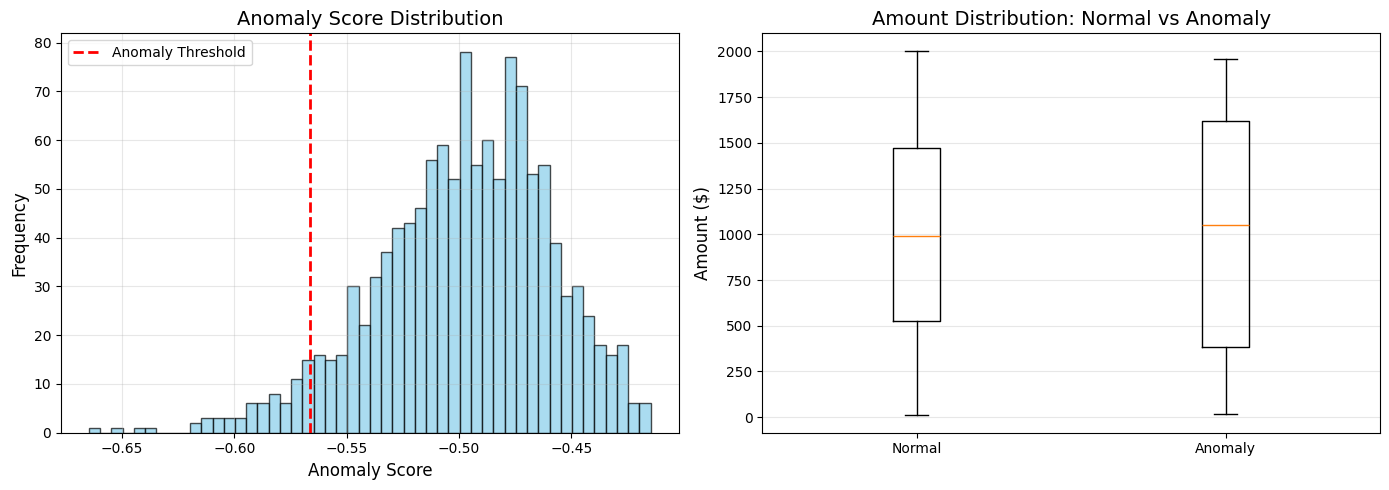

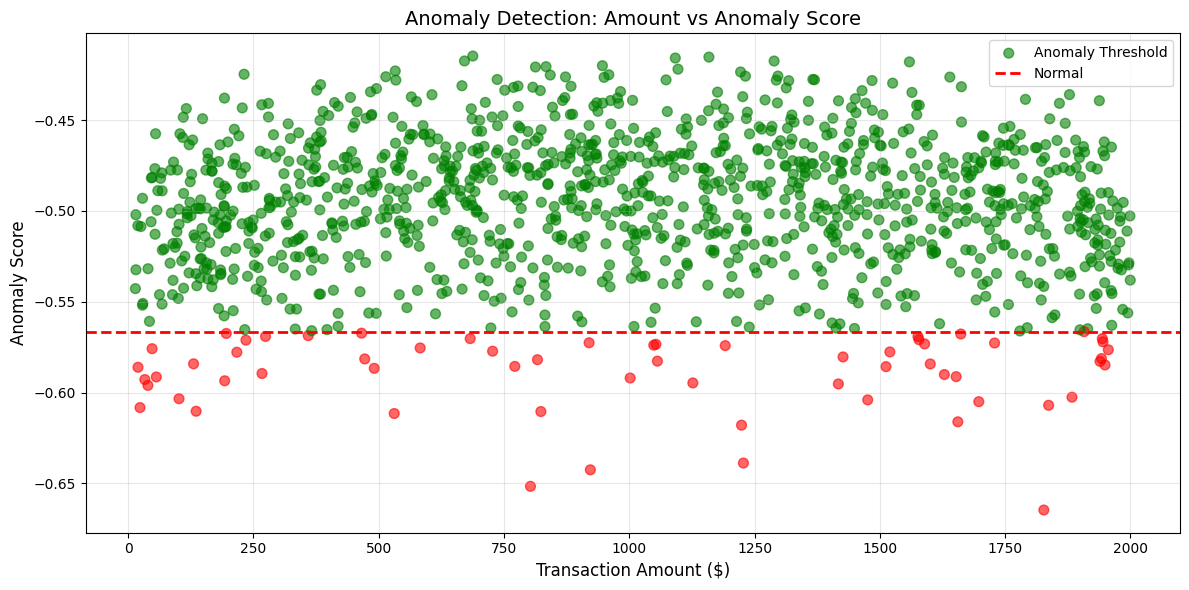

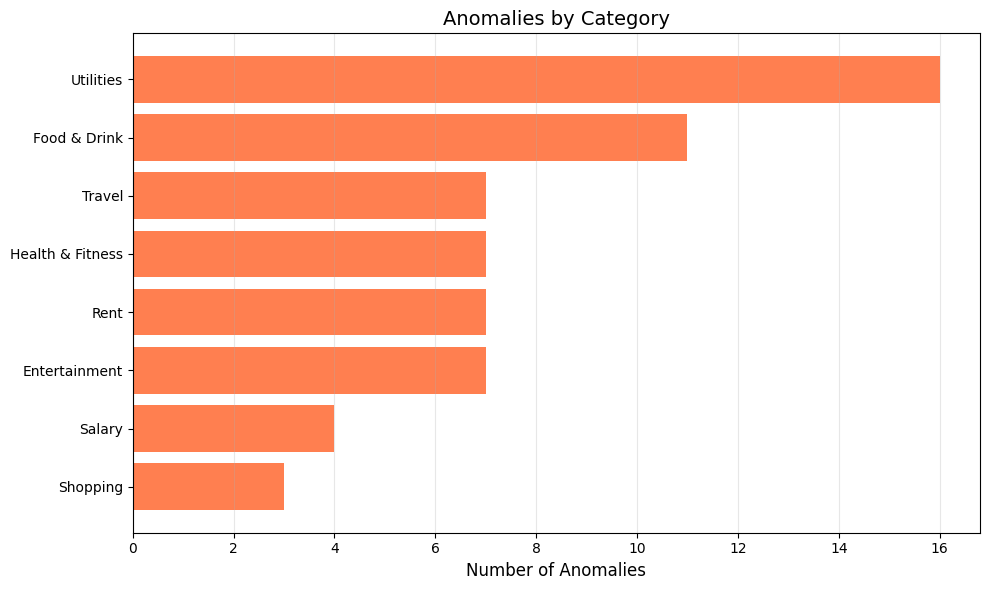

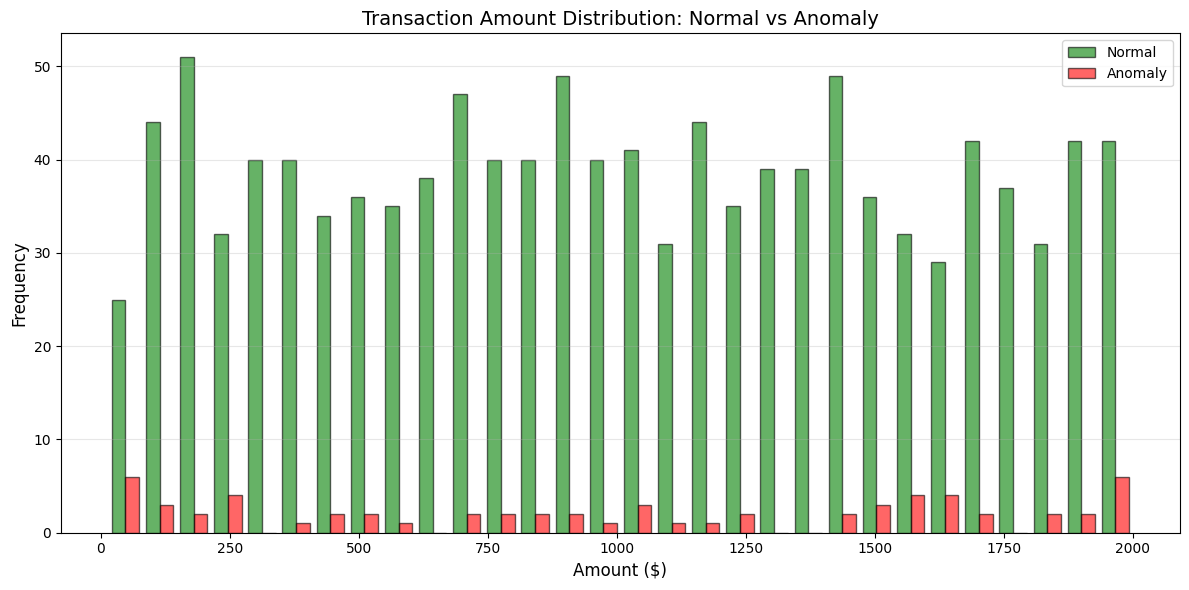

Visualizations complete

Step 4.9: Category-wise anomaly analysis...

Anomaly Rate by Category:
        Category  Total_Transactions  Normal  Anomalies  Anomaly_Rate
       Utilities               157.0   141.0       16.0     10.191083
    Food & Drink               149.0   138.0       11.0      7.382550
   Entertainment               143.0   136.0        7.0      4.895105
Health & Fitness               152.0   145.0        7.0      4.605263
          Travel               160.0   153.0        7.0      4.375000
            Rent               165.0   158.0        7.0      4.242424
          Salary               146.0   142.0        4.0      2.739726
        Shopping               150.0   147.0        3.0      2.000000

Step 4.10: Saving results...
Model saved: isolation_forest_model.pkl
Results saved: anomaly_detection_results.csv
  Total records: 1222
Anomalies saved: detected_anomalies.csv
  Anomaly records: 62
Category stats saved: category_anomaly_stats.csv

ISOLATION FOREST MODEL SU

In [6]:
# ============================================================================
# PHASE 2: MACHINE LEARNING MODELS
# STEP 4: ISOLATION FOREST - ANOMALY DETECTION
# ============================================================================

print("="*70)
print("STEP 4: ISOLATION FOREST - ANOMALY DETECTION")
print("="*70)

# ----------------------------------------------------------------------------
# 1. IMPORT ISOLATION FOREST
# ----------------------------------------------------------------------------
print("\nStep 4.1: Importing Isolation Forest...")

from sklearn.ensemble import IsolationForest
import time

print("Isolation Forest imported")

# ----------------------------------------------------------------------------
# 2. PREPARE DATA FOR ANOMALY DETECTION
# ----------------------------------------------------------------------------
print("\nStep 4.2: Preparing data for anomaly detection...")

# Use only expense transactions for anomaly detection
df_expenses = df_ml[df_ml['Type'] == 'Expense'].copy()

# Select features for anomaly detection
anomaly_features = [
    'Amount', 'Category_Avg_Amount', 'Rolling_7day_Avg',
    'Rolling_30day_Avg', 'Previous_Transaction_Amount',
    'Days_Since_Last_Transaction', 'Category_Encoded',
    'Day_of_Week', 'Month', 'Is_Weekend'
]

X_anomaly = df_expenses[anomaly_features].copy()

# Handle any remaining missing values
X_anomaly.fillna(X_anomaly.mean(), inplace=True)

print(f"Anomaly detection dataset prepared")
print(f"  Total expense transactions: {len(X_anomaly)}")
print(f"  Features: {len(anomaly_features)}")

# ----------------------------------------------------------------------------
# 3. SCALE FEATURES
# ----------------------------------------------------------------------------
print("\nStep 4.3: Scaling features...")

from sklearn.preprocessing import StandardScaler

scaler_anomaly = StandardScaler()
X_anomaly_scaled = scaler_anomaly.fit_transform(X_anomaly)

print("Features scaled")

# ----------------------------------------------------------------------------
# 4. BUILD ISOLATION FOREST MODEL
# ----------------------------------------------------------------------------
print("\nStep 4.4: Building Isolation Forest model...")

# Initialize model
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # Expect 5% anomalies
    max_samples='auto',
    random_state=42,
    n_jobs=-1
)

print("Isolation Forest model initialized")
print(f"  Contamination: 5%")
print(f"  Expected anomalies: {int(len(X_anomaly) * 0.05)}")

# ----------------------------------------------------------------------------
# 5. TRAIN MODEL AND DETECT ANOMALIES
# ----------------------------------------------------------------------------
print("\nStep 4.5: Training model and detecting anomalies...")

start_time = time.time()

# Fit and predict
anomaly_predictions = iso_forest.fit_predict(X_anomaly_scaled)

training_time = time.time() - start_time

# Get anomaly scores
anomaly_scores = iso_forest.score_samples(X_anomaly_scaled)

print(f"Anomaly detection complete")
print(f"  Training time: {training_time:.2f} seconds")

# ----------------------------------------------------------------------------
# 6. ANALYZE RESULTS
# ----------------------------------------------------------------------------
print("\nStep 4.6: Analyzing anomaly detection results...")

# Add predictions to dataframe
df_expenses['Anomaly'] = anomaly_predictions
df_expenses['Anomaly_Score'] = anomaly_scores

# -1 = anomaly, 1 = normal
normal_count = (anomaly_predictions == 1).sum()
anomaly_count = (anomaly_predictions == -1).sum()

print(f"\nAnomaly Detection Results:")
print(f"  Normal transactions: {normal_count} ({normal_count/len(df_expenses)*100:.2f}%)")
print(f"  Anomalous transactions: {anomaly_count} ({anomaly_count/len(df_expenses)*100:.2f}%)")

# Get anomalous transactions
anomalies_df = df_expenses[df_expenses['Anomaly'] == -1].copy()
normal_df = df_expenses[df_expenses['Anomaly'] == 1].copy()

print(f"\nAnomaly Statistics:")
print(f"  Mean anomaly amount: ${anomalies_df['Amount'].mean():.2f}")
print(f"  Mean normal amount: ${normal_df['Amount'].mean():.2f}")
print(f"  Max anomaly amount: ${anomalies_df['Amount'].max():.2f}")
print(f"  Min anomaly amount: ${anomalies_df['Amount'].min():.2f}")

# ----------------------------------------------------------------------------
# 7. TOP ANOMALIES
# ----------------------------------------------------------------------------
print("\nStep 4.7: Identifying top anomalies...")

# Sort by anomaly score (most negative = most anomalous)
top_anomalies = anomalies_df.sort_values('Anomaly_Score').head(10)

print("\nTop 10 Most Anomalous Transactions:")
print(top_anomalies[['Amount', 'Category', 'Anomaly_Score']].to_string(index=False))

# ----------------------------------------------------------------------------
# 8. VISUALIZATIONS
# ----------------------------------------------------------------------------
print("\nStep 4.8: Creating visualizations...")

# Figure 1: Anomaly Score Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(anomaly_scores, bins=50, color='skyblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=anomaly_scores[anomaly_predictions == -1].max(),
                color='red', linestyle='--', lw=2, label='Anomaly Threshold')
axes[0].set_xlabel('Anomaly Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Anomaly Score Distribution', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot comparison
data_to_plot = [normal_df['Amount'], anomalies_df['Amount']]
axes[1].boxplot(data_to_plot, labels=['Normal', 'Anomaly'])
axes[1].set_ylabel('Amount ($)', fontsize=12)
axes[1].set_title('Amount Distribution: Normal vs Anomaly', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Figure 2: Scatter plot - Amount vs Anomaly Score
plt.figure(figsize=(12, 6))
colors = ['green' if x == 1 else 'red' for x in anomaly_predictions]
plt.scatter(df_expenses['Amount'], anomaly_scores, c=colors, alpha=0.6, s=50)
plt.axhline(y=anomaly_scores[anomaly_predictions == -1].max(),
            color='red', linestyle='--', lw=2, label='Anomaly Threshold')
plt.xlabel('Transaction Amount ($)', fontsize=12)
plt.ylabel('Anomaly Score', fontsize=12)
plt.title('Anomaly Detection: Amount vs Anomaly Score', fontsize=14)
plt.legend(['Anomaly Threshold', 'Normal', 'Anomaly'], loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 3: Anomalies by Category
plt.figure(figsize=(10, 6))
anomaly_by_category = anomalies_df['Category'].value_counts()
plt.barh(range(len(anomaly_by_category)), anomaly_by_category.values, color='coral')
plt.yticks(range(len(anomaly_by_category)), anomaly_by_category.index)
plt.xlabel('Number of Anomalies', fontsize=12)
plt.title('Anomalies by Category', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Figure 4: Amount distribution by anomaly status
plt.figure(figsize=(12, 6))
plt.hist([normal_df['Amount'], anomalies_df['Amount']],
         bins=30, label=['Normal', 'Anomaly'],
         color=['green', 'red'], alpha=0.6, edgecolor='black')
plt.xlabel('Amount ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Transaction Amount Distribution: Normal vs Anomaly', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("Visualizations complete")

# ----------------------------------------------------------------------------
# 9. CATEGORY-WISE ANOMALY ANALYSIS
# ----------------------------------------------------------------------------
print("\nStep 4.9: Category-wise anomaly analysis...")

category_anomaly_stats = pd.DataFrame({
    'Category': [],
    'Total_Transactions': [],
    'Normal': [],
    'Anomalies': [],
    'Anomaly_Rate': []
})

for category in df_expenses['Category'].unique():
    cat_data = df_expenses[df_expenses['Category'] == category]
    total = len(cat_data)
    normal = (cat_data['Anomaly'] == 1).sum()
    anomaly = (cat_data['Anomaly'] == -1).sum()
    rate = (anomaly / total * 100) if total > 0 else 0

    category_anomaly_stats = pd.concat([category_anomaly_stats, pd.DataFrame({
        'Category': [category],
        'Total_Transactions': [total],
        'Normal': [normal],
        'Anomalies': [anomaly],
        'Anomaly_Rate': [rate]
    })], ignore_index=True)

category_anomaly_stats = category_anomaly_stats.sort_values('Anomaly_Rate', ascending=False)

print("\nAnomaly Rate by Category:")
print(category_anomaly_stats.to_string(index=False))

# ----------------------------------------------------------------------------
# 10. SAVE RESULTS
# ----------------------------------------------------------------------------
print("\nStep 4.10: Saving results...")

# Save model
import pickle
pickle.dump(iso_forest, open('isolation_forest_model.pkl', 'wb'))
pickle.dump(scaler_anomaly, open('scaler_anomaly.pkl', 'wb'))

print("Model saved: isolation_forest_model.pkl")

# Save anomaly results
anomaly_results = df_expenses[['Amount', 'Category', 'Anomaly', 'Anomaly_Score']].copy()
anomaly_results['Anomaly_Label'] = anomaly_results['Anomaly'].map({1: 'Normal', -1: 'Anomaly'})
anomaly_results = anomaly_results.sort_values('Anomaly_Score')
anomaly_results.to_csv('anomaly_detection_results.csv', index=False)

print("Results saved: anomaly_detection_results.csv")
print(f"  Total records: {len(anomaly_results)}")

# Save only anomalies
anomalies_only = anomaly_results[anomaly_results['Anomaly'] == -1].copy()
anomalies_only.to_csv('detected_anomalies.csv', index=False)

print("Anomalies saved: detected_anomalies.csv")
print(f"  Anomaly records: {len(anomalies_only)}")

# Save category stats
category_anomaly_stats.to_csv('category_anomaly_stats.csv', index=False)
print("Category stats saved: category_anomaly_stats.csv")

# ----------------------------------------------------------------------------
# 11. MODEL SUMMARY
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("ISOLATION FOREST MODEL SUMMARY")
print("="*70)

print(f"\nDataset:")
print(f"  Total expense transactions analyzed: {len(df_expenses)}")
print(f"  Features used: {len(anomaly_features)}")

print(f"\nAnomaly Detection Results:")
print(f"  Normal transactions: {normal_count} ({normal_count/len(df_expenses)*100:.2f}%)")
print(f"  Anomalous transactions: {anomaly_count} ({anomaly_count/len(df_expenses)*100:.2f}%)")
print(f"  Contamination parameter: 5%")

print(f"\nAmount Statistics:")
print(f"  Mean normal amount: ${normal_df['Amount'].mean():.2f}")
print(f"  Mean anomaly amount: ${anomalies_df['Amount'].mean():.2f}")
print(f"  Difference: ${abs(anomalies_df['Amount'].mean() - normal_df['Amount'].mean()):.2f}")

print(f"\nTop 3 Categories with Most Anomalies:")
for i, row in category_anomaly_stats.head(3).iterrows():
    print(f"  {int(i+1)}. {row['Category']}: {int(row['Anomalies'])} anomalies ({row['Anomaly_Rate']:.2f}%)")

print(f"\nModel Status: COMPLETE")
print("="*70)

# ----------------------------------------------------------------------------
# STEP 4 COMPLETE
# ----------------------------------------------------------------------------
print("\nSTEP 4: ISOLATION FOREST COMPLETE")
print("Ready for Step 5: K-Means Clustering (Spending Personas)")
print("="*70)

STEP 5: K-MEANS CLUSTERING - SPENDING PERSONAS

Step 5.1: Importing libraries...
Libraries imported

Step 5.2: Preparing data for clustering...
Clustering dataset prepared
  Total months: 60
  Features: 11

Step 5.3: Scaling features...
Features scaled

Step 5.4: Determining optimal number of clusters...
Optimal cluster analysis complete


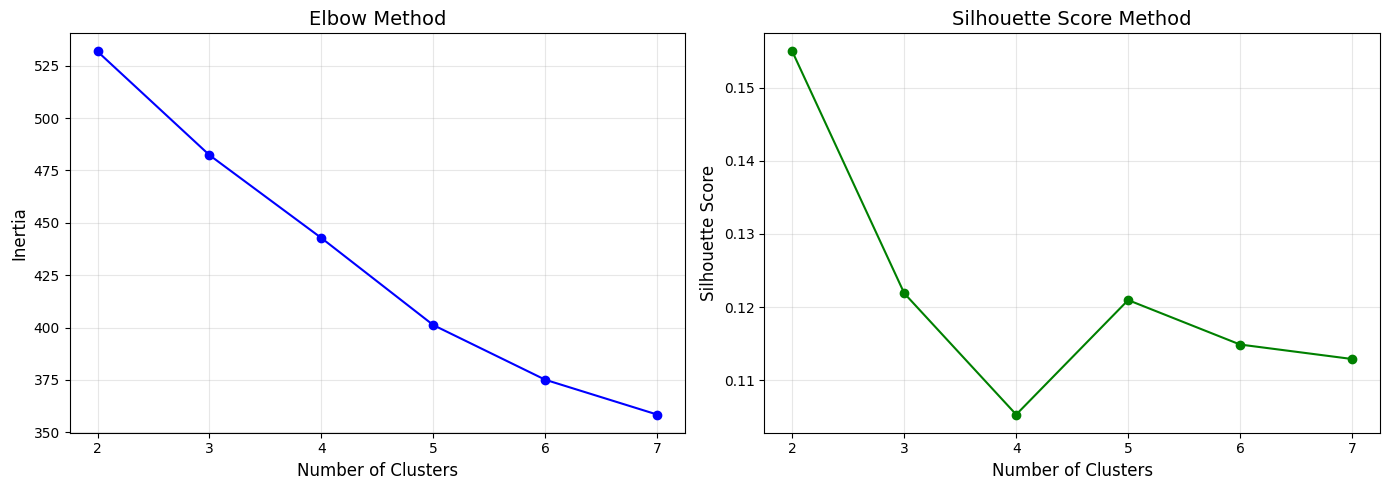

Optimal number of clusters: 2
Best silhouette score: 0.1549

Step 5.5: Building K-Means model with 2 clusters...
K-Means clustering complete
  Training time: 0.02 seconds
  Number of clusters: 2

Step 5.6: Analyzing clusters...

Cluster Statistics:
Category Total_Spending                    Transaction_Count Avg_Transaction
                   mean          std count              mean            mean
Cluster                                                                     
0          24455.197742  3299.683638    31         23.451613     1046.720359
1          16175.284138  2624.826356    29         17.068966      958.227352

Cluster Distribution:
  Cluster 0: 31 months (51.67%)
  Cluster 1: 29 months (48.33%)

Step 5.7: Defining spending personas...

Spending Personas:
  Cluster 0: Big Spender - 31 months - Avg: $24455.20
  Cluster 1: Frugal Saver - 29 months - Avg: $16175.28

Step 5.8: Creating visualizations...


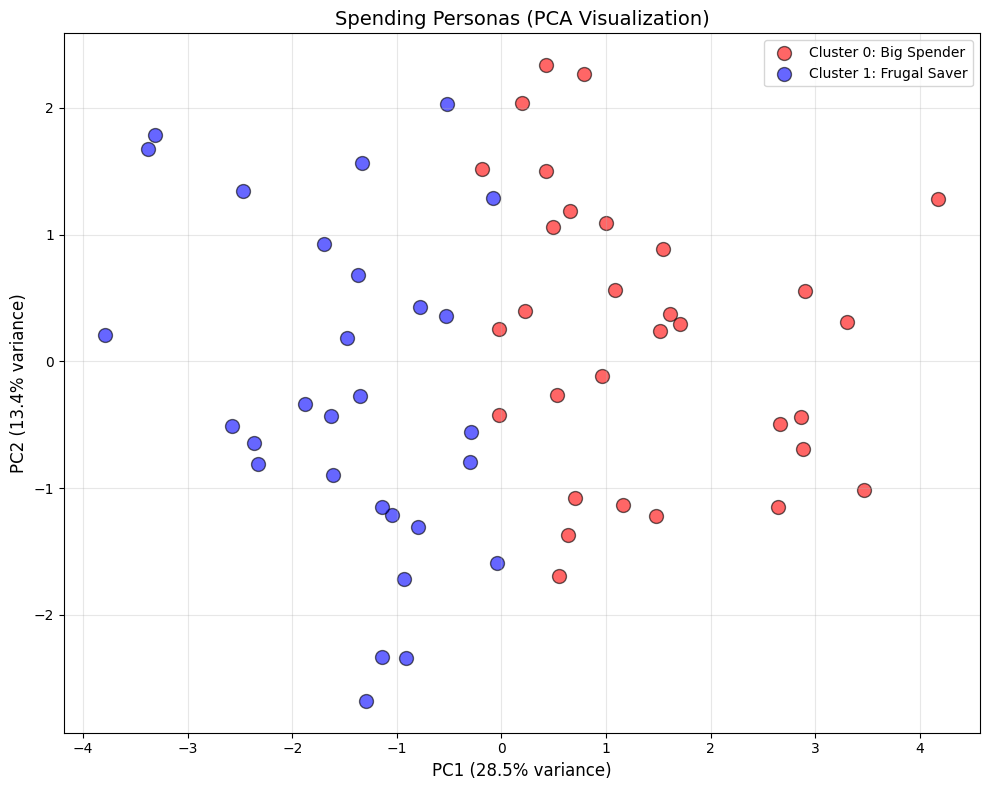

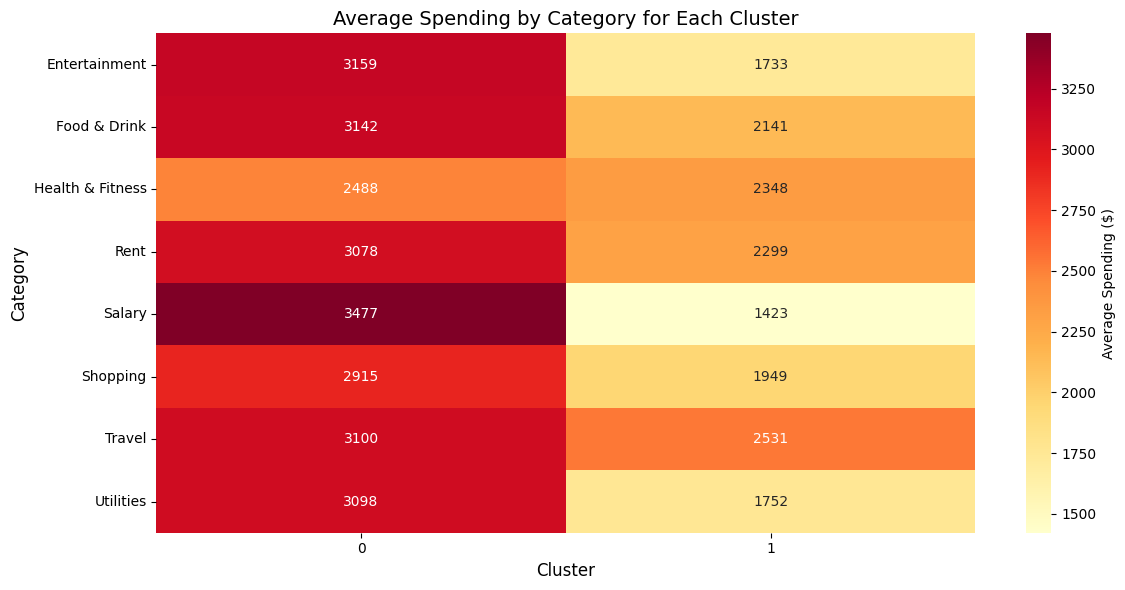

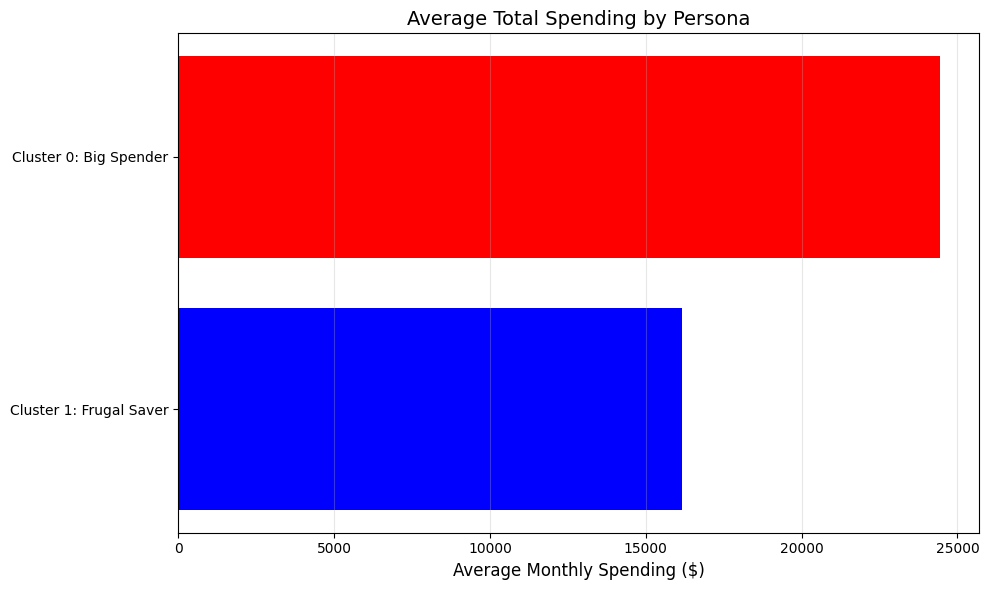

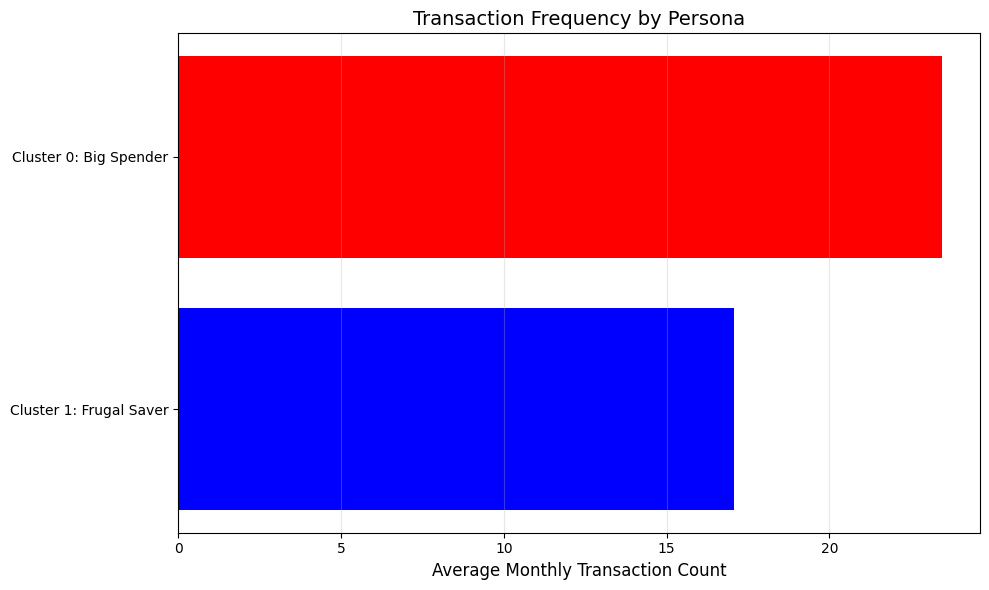

Visualizations complete

Step 5.9: Creating detailed cluster profiles...

CLUSTER 0: Big Spender

Size: 31 months (51.67%)
Average Total Spending: $24455.20
Average Transaction Count: 23
Average Transaction Amount: $1046.72

Top 3 Spending Categories:
  1. Salary: $3477.15
  2. Entertainment: $3158.62
  3. Food & Drink: $3141.83

CLUSTER 1: Frugal Saver

Size: 29 months (48.33%)
Average Total Spending: $16175.28
Average Transaction Count: 17
Average Transaction Amount: $958.23

Top 3 Spending Categories:
  1. Travel: $2531.26
  2. Health & Fitness: $2347.55
  3. Rent: $2298.97

Step 5.10: Saving results...
Models saved
Personas saved: spending_personas.csv
  Records: 60
Cluster profiles saved: cluster_profiles.csv

K-MEANS CLUSTERING MODEL SUMMARY

Model Configuration:
  Number of clusters: 2
  Silhouette score: 0.1549
  Training time: 0.02 seconds

Dataset:
  Total months analyzed: 60
  Features used: 11

Spending Personas Identified:
  Big Spender: 31 months (51.67%) - Avg: $24455.20

In [7]:
# ============================================================================
# PHASE 2: MACHINE LEARNING MODELS
# STEP 5: K-MEANS CLUSTERING - SPENDING PERSONAS
# ============================================================================

print("="*70)
print("STEP 5: K-MEANS CLUSTERING - SPENDING PERSONAS")
print("="*70)

# ----------------------------------------------------------------------------
# 1. IMPORT LIBRARIES
# ----------------------------------------------------------------------------
print("\nStep 5.1: Importing libraries...")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import time

print("Libraries imported")

# ----------------------------------------------------------------------------
# 2. PREPARE DATA FOR CLUSTERING
# ----------------------------------------------------------------------------
print("\nStep 5.2: Preparing data for clustering...")

# Create monthly spending profile for each month
df_clustering = df.copy()
df_clustering['Year_Month'] = df_clustering['Date'].dt.to_period('M')

# Aggregate spending by month and category
monthly_spending = df_clustering[df_clustering['Type'] == 'Expense'].pivot_table(
    values='Amount',
    index='Year_Month',
    columns='Category',
    aggfunc='sum',
    fill_value=0
)

# Add total monthly spending
monthly_spending['Total_Spending'] = monthly_spending.sum(axis=1)

# Add transaction counts
monthly_counts = df_clustering[df_clustering['Type'] == 'Expense'].groupby('Year_Month').size()
monthly_spending['Transaction_Count'] = monthly_counts

# Add average transaction amount
monthly_spending['Avg_Transaction'] = monthly_spending['Total_Spending'] / monthly_spending['Transaction_Count']

print(f"Clustering dataset prepared")
print(f"  Total months: {len(monthly_spending)}")
print(f"  Features: {len(monthly_spending.columns)}")

# ----------------------------------------------------------------------------
# 3. SCALE FEATURES
# ----------------------------------------------------------------------------
print("\nStep 5.3: Scaling features...")

from sklearn.preprocessing import StandardScaler

scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(monthly_spending)

print("Features scaled")

# ----------------------------------------------------------------------------
# 4. DETERMINE OPTIMAL NUMBER OF CLUSTERS
# ----------------------------------------------------------------------------
print("\nStep 5.4: Determining optimal number of clusters...")

# Elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, kmeans.labels_))

print(f"Optimal cluster analysis complete")

# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, marker='o', color='blue')
axes[0].set_xlabel('Number of Clusters', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14)
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, marker='o', color='green')
axes[1].set_xlabel('Number of Clusters', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score Method', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select optimal K (highest silhouette score)
optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {max(silhouette_scores):.4f}")

# ----------------------------------------------------------------------------
# 5. BUILD K-MEANS MODEL
# ----------------------------------------------------------------------------
print(f"\nStep 5.5: Building K-Means model with {optimal_k} clusters...")

start_time = time.time()

# Build final model
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster)

training_time = time.time() - start_time

print(f"K-Means clustering complete")
print(f"  Training time: {training_time:.2f} seconds")
print(f"  Number of clusters: {optimal_k}")

# Add cluster labels to dataframe
monthly_spending['Cluster'] = cluster_labels

# ----------------------------------------------------------------------------
# 6. ANALYZE CLUSTERS
# ----------------------------------------------------------------------------
print("\nStep 5.6: Analyzing clusters...")

# Cluster statistics
cluster_stats = monthly_spending.groupby('Cluster').agg({
    'Total_Spending': ['mean', 'std', 'count'],
    'Transaction_Count': 'mean',
    'Avg_Transaction': 'mean'
})

print("\nCluster Statistics:")
print(cluster_stats)

# Cluster sizes
print("\nCluster Distribution:")
cluster_counts = monthly_spending['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / len(monthly_spending)) * 100
    print(f"  Cluster {cluster}: {count} months ({percentage:.2f}%)")

# ----------------------------------------------------------------------------
# 7. DEFINE SPENDING PERSONAS
# ----------------------------------------------------------------------------
print("\nStep 5.7: Defining spending personas...")

# Calculate mean spending by category for each cluster
cluster_profiles = monthly_spending.groupby('Cluster').mean()

# Create persona names based on spending patterns
persona_names = {}
for cluster in range(optimal_k):
    total_spending = cluster_profiles.loc[cluster, 'Total_Spending']

    if total_spending < monthly_spending['Total_Spending'].quantile(0.33):
        persona = "Frugal Saver"
    elif total_spending < monthly_spending['Total_Spending'].quantile(0.67):
        persona = "Moderate Spender"
    else:
        persona = "Big Spender"

    persona_names[cluster] = persona

print("\nSpending Personas:")
for cluster, persona in persona_names.items():
    count = cluster_counts[cluster]
    avg_spending = cluster_profiles.loc[cluster, 'Total_Spending']
    print(f"  Cluster {cluster}: {persona} - {count} months - Avg: ${avg_spending:.2f}")

# Add persona names to dataframe
monthly_spending['Persona'] = monthly_spending['Cluster'].map(persona_names)

# ----------------------------------------------------------------------------
# 8. VISUALIZATIONS
# ----------------------------------------------------------------------------
print("\nStep 5.8: Creating visualizations...")

# Figure 1: PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
for cluster in range(optimal_k):
    mask = cluster_labels == cluster
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=colors[cluster], label=f'Cluster {cluster}: {persona_names[cluster]}',
               alpha=0.6, s=100, edgecolors='black')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
plt.title('Spending Personas (PCA Visualization)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Figure 2: Cluster centers heatmap
category_columns = [col for col in monthly_spending.columns if col not in
                   ['Total_Spending', 'Transaction_Count', 'Avg_Transaction', 'Cluster', 'Persona']]

cluster_centers = monthly_spending.groupby('Cluster')[category_columns].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_centers.T, annot=True, fmt='.0f', cmap='YlOrRd',
           cbar_kws={'label': 'Average Spending ($)'})
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.title('Average Spending by Category for Each Cluster', fontsize=14)
plt.tight_layout()
plt.show()

# Figure 3: Total spending by cluster
plt.figure(figsize=(10, 6))
cluster_spending = monthly_spending.groupby('Cluster')['Total_Spending'].mean().sort_values()
colors_bar = [colors[i] for i in cluster_spending.index]
plt.barh(range(len(cluster_spending)), cluster_spending.values, color=colors_bar)
plt.yticks(range(len(cluster_spending)),
          [f'Cluster {i}: {persona_names[i]}' for i in cluster_spending.index])
plt.xlabel('Average Monthly Spending ($)', fontsize=12)
plt.title('Average Total Spending by Persona', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Figure 4: Transaction count by cluster
plt.figure(figsize=(10, 6))
cluster_transactions = monthly_spending.groupby('Cluster')['Transaction_Count'].mean().sort_values()
colors_bar2 = [colors[i] for i in cluster_transactions.index]
plt.barh(range(len(cluster_transactions)), cluster_transactions.values, color=colors_bar2)
plt.yticks(range(len(cluster_transactions)),
          [f'Cluster {i}: {persona_names[i]}' for i in cluster_transactions.index])
plt.xlabel('Average Monthly Transaction Count', fontsize=12)
plt.title('Transaction Frequency by Persona', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("Visualizations complete")

# ----------------------------------------------------------------------------
# 9. DETAILED CLUSTER PROFILES
# ----------------------------------------------------------------------------
print("\nStep 5.9: Creating detailed cluster profiles...")

for cluster in range(optimal_k):
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster}: {persona_names[cluster]}")
    print(f"{'='*70}")

    cluster_data = monthly_spending[monthly_spending['Cluster'] == cluster]

    print(f"\nSize: {len(cluster_data)} months ({len(cluster_data)/len(monthly_spending)*100:.2f}%)")
    print(f"Average Total Spending: ${cluster_data['Total_Spending'].mean():.2f}")
    print(f"Average Transaction Count: {cluster_data['Transaction_Count'].mean():.0f}")
    print(f"Average Transaction Amount: ${cluster_data['Avg_Transaction'].mean():.2f}")

    print(f"\nTop 3 Spending Categories:")
    top_categories = cluster_data[category_columns].mean().sort_values(ascending=False).head(3)
    for i, (cat, amount) in enumerate(top_categories.items(), 1):
        print(f"  {i}. {cat}: ${amount:.2f}")

# ----------------------------------------------------------------------------
# 10. SAVE RESULTS
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("Step 5.10: Saving results...")

# Save model
import pickle
pickle.dump(kmeans, open('kmeans_model.pkl', 'wb'))
pickle.dump(scaler_cluster, open('scaler_cluster.pkl', 'wb'))
pickle.dump(pca, open('pca_model.pkl', 'wb'))

print("Models saved")

# Save cluster results
monthly_spending.to_csv('spending_personas.csv')
print("Personas saved: spending_personas.csv")
print(f"  Records: {len(monthly_spending)}")

# Save cluster profiles
cluster_profiles_df = monthly_spending.groupby(['Cluster', 'Persona']).mean()
cluster_profiles_df.to_csv('cluster_profiles.csv')
print("Cluster profiles saved: cluster_profiles.csv")

# ----------------------------------------------------------------------------
# 11. MODEL SUMMARY
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("K-MEANS CLUSTERING MODEL SUMMARY")
print("="*70)

print(f"\nModel Configuration:")
print(f"  Number of clusters: {optimal_k}")
print(f"  Silhouette score: {silhouette_score(X_cluster, cluster_labels):.4f}")
print(f"  Training time: {training_time:.2f} seconds")

print(f"\nDataset:")
print(f"  Total months analyzed: {len(monthly_spending)}")
print(f"  Features used: {len(category_columns) + 3}")

print(f"\nSpending Personas Identified:")
for cluster in range(optimal_k):
    count = cluster_counts[cluster]
    percentage = (count / len(monthly_spending)) * 100
    avg_spending = cluster_profiles.loc[cluster, 'Total_Spending']
    print(f"  {persona_names[cluster]}: {count} months ({percentage:.2f}%) - Avg: ${avg_spending:.2f}")

print(f"\nPCA Variance Explained:")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"  Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")

print(f"\nModel Status: COMPLETE")
print("="*70)

# ----------------------------------------------------------------------------
# STEP 5 COMPLETE
# ----------------------------------------------------------------------------
print("\nSTEP 5: K-MEANS CLUSTERING COMPLETE")
print("Ready for Step 6: Time Series Forecasting (ARIMA)")
print("="*70)

STEP 6: TIME SERIES FORECASTING - ARIMA

Step 6.1: Installing libraries...
Libraries imported

Step 6.2: Preparing time series data...
Time series prepared
  Total periods: 60
  Start date: 2020-01-01 00:00:00
  End date: 2024-12-01 00:00:00
  Mean monthly spending: $20453.24

Step 6.3: Visualizing time series...


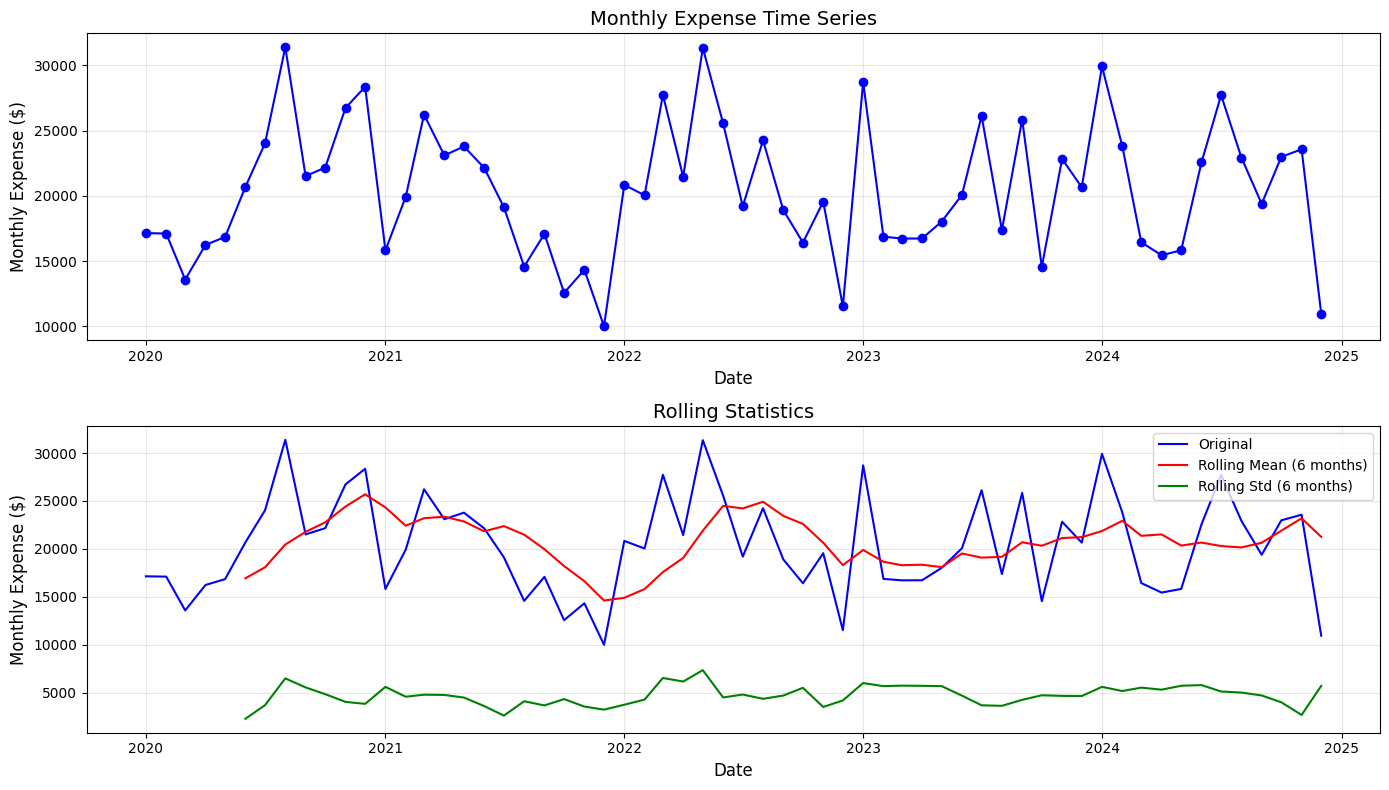

Time series visualization complete

Step 6.4: Testing for stationarity...
ADF Statistic: -5.8385
p-value: 0.0000
Critical Values:
  1%: -3.5464
  5%: -2.9119
  10%: -2.5937
Result: Series is STATIONARY

Step 6.5: Creating ACF and PACF plots...


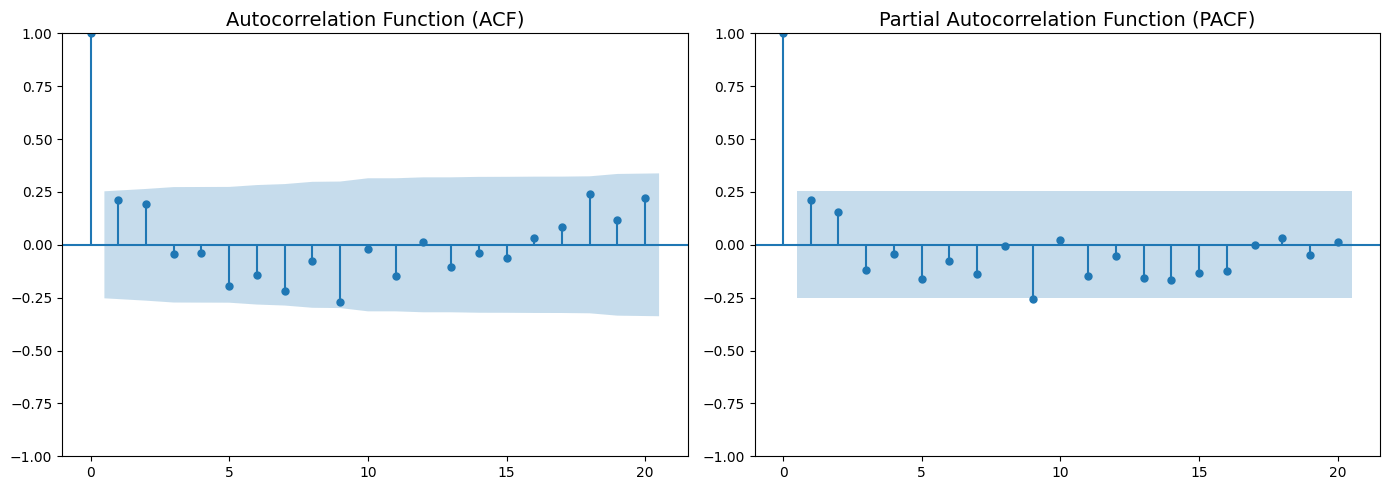

ACF and PACF plots complete

Step 6.6: Splitting data into train and test sets...
Training set: 48 months
Test set: 12 months

Step 6.7: Building ARIMA model...
Testing different ARIMA parameters...

Best ARIMA parameters: (0, 1, 1)
Best AIC: 944.65

Step 6.8: Model summary...
                               SARIMAX Results                                
Dep. Variable:                 Amount   No. Observations:                   48
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -470.324
Date:                Fri, 30 Jan 2026   AIC                            944.648
Time:                        08:09:39   BIC                            948.348
Sample:                    01-01-2020   HQIC                           946.040
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

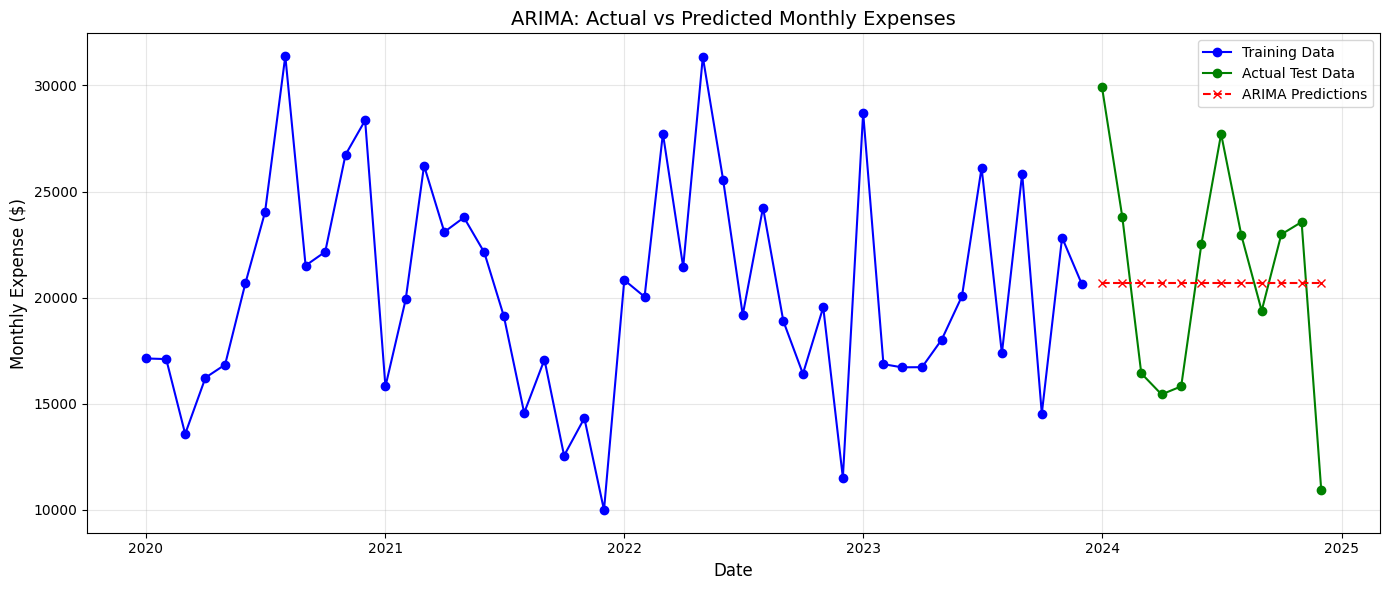

Prediction visualization complete

Step 6.11: Forecasting future 6 months...

Future 6-Month Forecast:
  2025-01: $17719.54
  2025-02: $17719.54
  2025-03: $17719.54
  2025-04: $17719.54
  2025-05: $17719.54
  2025-06: $17719.54

Step 6.12: Visualizing forecast with confidence intervals...


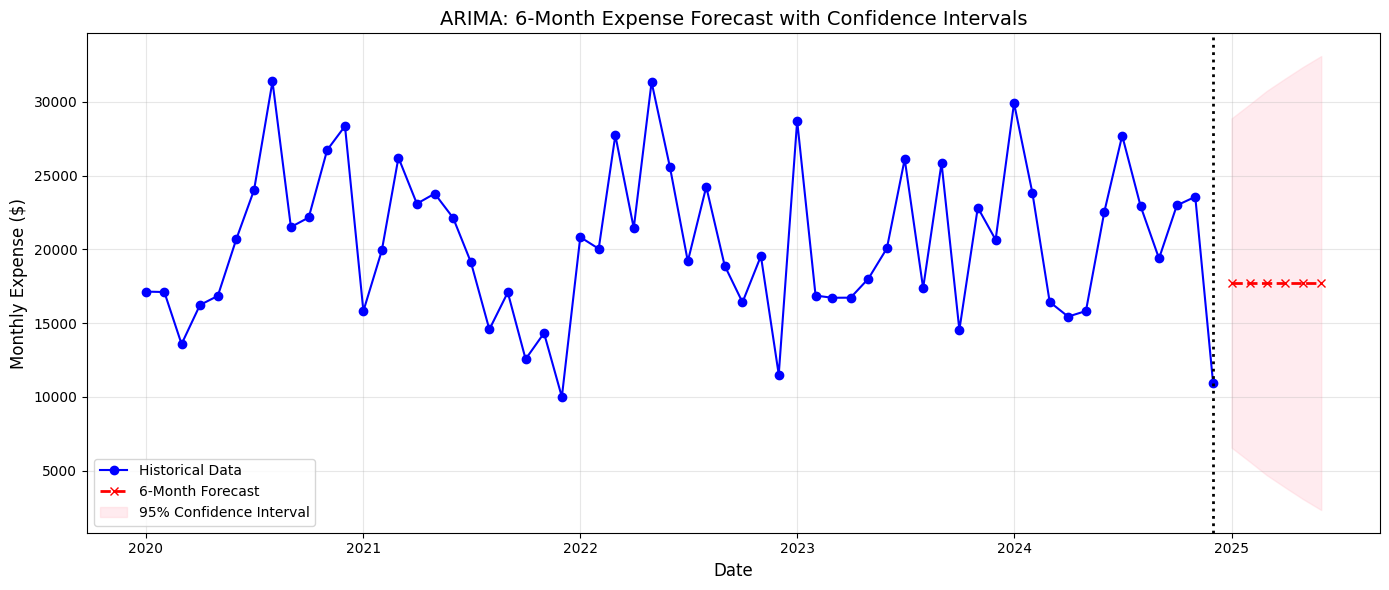

Forecast visualization complete

Step 6.13: Analyzing residuals...


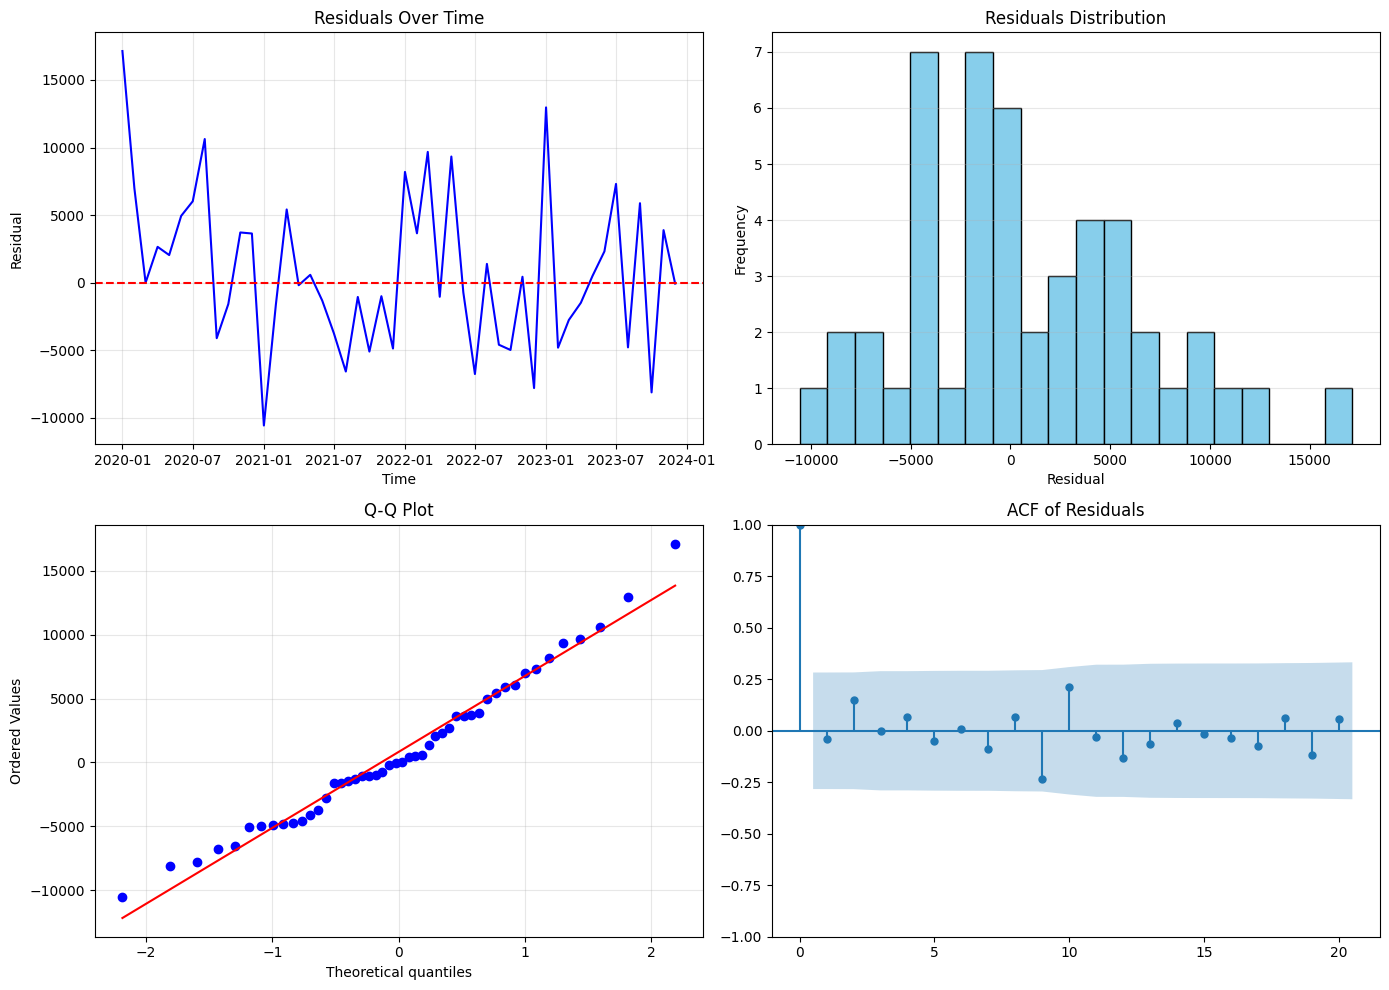

Residual analysis complete

Step 6.14: Saving results...
Forecast saved: arima_forecast_6months.csv
Test predictions saved: arima_test_predictions.csv
Model saved: arima_model.pkl

ARIMA TIME SERIES FORECASTING SUMMARY

Model Configuration:
  ARIMA Order (p,d,q): (0, 1, 1)
  AIC: 944.65

Dataset:
  Total periods: 60 months
  Training periods: 48 months
  Test periods: 12 months

Model Performance:
  RMSE: $5262.59
  MAE: $4505.69
  R2 Score: -0.0026
  MAPE: 24.67%

6-Month Forecast Summary:
  Average forecast: $17719.54
  Min forecast: $17719.54
  Max forecast: $17719.54

Model Status: COMPLETE

STEP 6: ARIMA TIME SERIES FORECASTING COMPLETE

ALL MACHINE LEARNING MODELS COMPLETED!

Models Completed:
  1. XGBoost Regressor - DONE
  2. Random Forest Regressor - DONE
  3. Isolation Forest (Anomaly Detection) - DONE
  4. K-Means Clustering (Spending Personas) - DONE
  5. ARIMA (Time Series Forecasting) - DONE

PHASE 2: MACHINE LEARNING - COMPLETE


In [8]:
# ============================================================================
# PHASE 2: MACHINE LEARNING MODELS
# STEP 6: TIME SERIES FORECASTING - ARIMA
# ============================================================================

print("="*70)
print("STEP 6: TIME SERIES FORECASTING - ARIMA")
print("="*70)

# ----------------------------------------------------------------------------
# 1. INSTALL AND IMPORT LIBRARIES
# ----------------------------------------------------------------------------
print("\nStep 6.1: Installing libraries...")

!pip install statsmodels -q

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported")

# ----------------------------------------------------------------------------
# 2. PREPARE TIME SERIES DATA
# ----------------------------------------------------------------------------
print("\nStep 6.2: Preparing time series data...")

# Create monthly expense time series
monthly_expenses = df[df['Type'] == 'Expense'].groupby(
    df[df['Type'] == 'Expense']['Date'].dt.to_period('M')
)['Amount'].sum()

# Convert to datetime index
monthly_expenses.index = monthly_expenses.index.to_timestamp()
monthly_expenses = monthly_expenses.sort_index()

print(f"Time series prepared")
print(f"  Total periods: {len(monthly_expenses)}")
print(f"  Start date: {monthly_expenses.index[0]}")
print(f"  End date: {monthly_expenses.index[-1]}")
print(f"  Mean monthly spending: ${monthly_expenses.mean():.2f}")

# ----------------------------------------------------------------------------
# 3. VISUALIZE TIME SERIES
# ----------------------------------------------------------------------------
print("\nStep 6.3: Visualizing time series...")

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original series
axes[0].plot(monthly_expenses.index, monthly_expenses.values, marker='o', color='blue')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Monthly Expense ($)', fontsize=12)
axes[0].set_title('Monthly Expense Time Series', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Rolling statistics
rolling_mean = monthly_expenses.rolling(window=6).mean()
rolling_std = monthly_expenses.rolling(window=6).std()

axes[1].plot(monthly_expenses.index, monthly_expenses.values, label='Original', color='blue')
axes[1].plot(rolling_mean.index, rolling_mean.values, label='Rolling Mean (6 months)', color='red')
axes[1].plot(rolling_std.index, rolling_std.values, label='Rolling Std (6 months)', color='green')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Monthly Expense ($)', fontsize=12)
axes[1].set_title('Rolling Statistics', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Time series visualization complete")

# ----------------------------------------------------------------------------
# 4. STATIONARITY TEST
# ----------------------------------------------------------------------------
print("\nStep 6.4: Testing for stationarity...")

def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")

    if result[1] <= 0.05:
        print("Result: Series is STATIONARY")
        return True
    else:
        print("Result: Series is NON-STATIONARY")
        return False

is_stationary = test_stationarity(monthly_expenses)

# ----------------------------------------------------------------------------
# 5. ACF AND PACF PLOTS
# ----------------------------------------------------------------------------
print("\nStep 6.5: Creating ACF and PACF plots...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(monthly_expenses, lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14)

plot_pacf(monthly_expenses, lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14)

plt.tight_layout()
plt.show()

print("ACF and PACF plots complete")

# ----------------------------------------------------------------------------
# 6. TRAIN-TEST SPLIT
# ----------------------------------------------------------------------------
print("\nStep 6.6: Splitting data into train and test sets...")

# Use 80% for training, 20% for testing
train_size = int(len(monthly_expenses) * 0.8)
train_data = monthly_expenses[:train_size]
test_data = monthly_expenses[train_size:]

print(f"Training set: {len(train_data)} months")
print(f"Test set: {len(test_data)} months")

# ----------------------------------------------------------------------------
# 7. BUILD ARIMA MODEL
# ----------------------------------------------------------------------------
print("\nStep 6.7: Building ARIMA model...")

# Try different ARIMA parameters
print("Testing different ARIMA parameters...")

best_aic = np.inf
best_order = None
best_model = None

# Grid search for best parameters
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train_data, order=(p, d, q))
                fitted_model = model.fit()

                if fitted_model.aic < best_aic:
                    best_aic = fitted_model.aic
                    best_order = (p, d, q)
                    best_model = fitted_model
            except:
                continue

print(f"\nBest ARIMA parameters: {best_order}")
print(f"Best AIC: {best_aic:.2f}")

# ----------------------------------------------------------------------------
# 8. MODEL SUMMARY
# ----------------------------------------------------------------------------
print("\nStep 6.8: Model summary...")

print(best_model.summary())

# ----------------------------------------------------------------------------
# 9. MAKE PREDICTIONS
# ----------------------------------------------------------------------------
print("\nStep 6.9: Making predictions...")

# Predict on test set
predictions = best_model.forecast(steps=len(test_data))

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(test_data, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, predictions)
r2 = r2_score(test_data, predictions)
mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

print(f"\nModel Performance on Test Set:")
print(f"  RMSE: ${rmse:.2f}")
print(f"  MAE: ${mae:.2f}")
print(f"  R2 Score: {r2:.4f}")
print(f"  MAPE: {mape:.2f}%")

# ----------------------------------------------------------------------------
# 10. VISUALIZE PREDICTIONS
# ----------------------------------------------------------------------------
print("\nStep 6.10: Visualizing predictions...")

plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train_data.index, train_data.values, label='Training Data', color='blue', marker='o')

# Plot test data
plt.plot(test_data.index, test_data.values, label='Actual Test Data', color='green', marker='o')

# Plot predictions
plt.plot(test_data.index, predictions, label='ARIMA Predictions', color='red', marker='x', linestyle='--')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Monthly Expense ($)', fontsize=12)
plt.title('ARIMA: Actual vs Predicted Monthly Expenses', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Prediction visualization complete")

# ----------------------------------------------------------------------------
# 11. FORECAST FUTURE
# ----------------------------------------------------------------------------
print("\nStep 6.11: Forecasting future 6 months...")

# Refit model on entire dataset
final_model = ARIMA(monthly_expenses, order=best_order)
final_fitted = final_model.fit()

# Forecast next 6 months
forecast_steps = 6
forecast = final_fitted.forecast(steps=forecast_steps)

# Create future dates
last_date = monthly_expenses.index[-1]
future_dates = pd.date_range(start=last_date, periods=forecast_steps+1, freq='MS')[1:]

print(f"\nFuture 6-Month Forecast:")
for date, value in zip(future_dates, forecast):
    print(f"  {date.strftime('%Y-%m')}: ${value:.2f}")

# Get confidence intervals
forecast_result = final_fitted.get_forecast(steps=forecast_steps)
forecast_ci = forecast_result.conf_int()

# ----------------------------------------------------------------------------
# 12. VISUALIZE FORECAST
# ----------------------------------------------------------------------------
print("\nStep 6.12: Visualizing forecast with confidence intervals...")

plt.figure(figsize=(14, 6))

# Historical data
plt.plot(monthly_expenses.index, monthly_expenses.values, label='Historical Data',
         color='blue', marker='o')

# Forecast
plt.plot(future_dates, forecast, label='6-Month Forecast',
         color='red', marker='x', linestyle='--', linewidth=2)

# Confidence intervals
plt.fill_between(future_dates,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1],
                color='pink', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Monthly Expense ($)', fontsize=12)
plt.title('ARIMA: 6-Month Expense Forecast with Confidence Intervals', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=monthly_expenses.index[-1], color='black', linestyle=':', linewidth=2, label='Forecast Start')
plt.tight_layout()
plt.show()

print("Forecast visualization complete")

# ----------------------------------------------------------------------------
# 13. RESIDUAL ANALYSIS
# ----------------------------------------------------------------------------
print("\nStep 6.13: Analyzing residuals...")

residuals = best_model.resid

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals plot
axes[0, 0].plot(residuals, color='blue')
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals Over Time', fontsize=12)
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

# Residuals histogram
axes[0, 1].hist(residuals, bins=20, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Residuals Distribution', fontsize=12)
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# ACF of residuals
plot_acf(residuals, lags=20, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Residuals', fontsize=12)

plt.tight_layout()
plt.show()

print("Residual analysis complete")

# ----------------------------------------------------------------------------
# 14. SAVE RESULTS
# ----------------------------------------------------------------------------
print("\nStep 6.14: Saving results...")

# Save forecast
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': forecast,
    'Lower_CI': forecast_ci.iloc[:, 0].values,
    'Upper_CI': forecast_ci.iloc[:, 1].values
})
forecast_df.to_csv('arima_forecast_6months.csv', index=False)
print("Forecast saved: arima_forecast_6months.csv")

# Save predictions on test set
test_predictions_df = pd.DataFrame({
    'Date': test_data.index,
    'Actual': test_data.values,
    'Predicted': predictions
})
test_predictions_df.to_csv('arima_test_predictions.csv', index=False)
print("Test predictions saved: arima_test_predictions.csv")

# Save model
import pickle
pickle.dump(final_fitted, open('arima_model.pkl', 'wb'))
print("Model saved: arima_model.pkl")

# ----------------------------------------------------------------------------
# 15. MODEL SUMMARY
# ----------------------------------------------------------------------------
print("\n" + "="*70)
print("ARIMA TIME SERIES FORECASTING SUMMARY")
print("="*70)

print(f"\nModel Configuration:")
print(f"  ARIMA Order (p,d,q): {best_order}")
print(f"  AIC: {best_aic:.2f}")

print(f"\nDataset:")
print(f"  Total periods: {len(monthly_expenses)} months")
print(f"  Training periods: {len(train_data)} months")
print(f"  Test periods: {len(test_data)} months")

print(f"\nModel Performance:")
print(f"  RMSE: ${rmse:.2f}")
print(f"  MAE: ${mae:.2f}")
print(f"  R2 Score: {r2:.4f}")
print(f"  MAPE: {mape:.2f}%")

print(f"\n6-Month Forecast Summary:")
print(f"  Average forecast: ${forecast.mean():.2f}")
print(f"  Min forecast: ${forecast.min():.2f}")
print(f"  Max forecast: ${forecast.max():.2f}")

print(f"\nModel Status: COMPLETE")
print("="*70)

# ----------------------------------------------------------------------------
# STEP 6 COMPLETE
# ----------------------------------------------------------------------------
print("\nSTEP 6: ARIMA TIME SERIES FORECASTING COMPLETE")
print("="*70)
print("\nALL MACHINE LEARNING MODELS COMPLETED!")
print("="*70)
print("\nModels Completed:")
print("  1. XGBoost Regressor - DONE")
print("  2. Random Forest Regressor - DONE")
print("  3. Isolation Forest (Anomaly Detection) - DONE")
print("  4. K-Means Clustering (Spending Personas) - DONE")
print("  5. ARIMA (Time Series Forecasting) - DONE")
print("\nPHASE 2: MACHINE LEARNING - COMPLETE")
print("="*70)

In [9]:
# Copy all CSV files to Google Drive
import os
import shutil

# Source: Current Colab directory
source_dir = '/content/'

# Destination: Google Drive folder
dest_dir = '/content/drive/MyDrive/project_p1/'

# Create destination folder if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# List of files to copy
files_to_copy = [
    'anomaly_detection_results.csv',
    'arima_forecast_6months.csv',
    'arima_test_predictions.csv',
    'category_anomaly_stats.csv',
    'cluster_profiles.csv',
    'detected_anomalies.csv',
    'model_comparison.csv',
    'xgb_predictions.csv',
    'rf_predictions.csv',
    'spending_personas.csv'
]

# Copy each file
print("Copying files to Google Drive...")
for file in files_to_copy:
    source_path = os.path.join(source_dir, file)
    dest_path = os.path.join(dest_dir, file)

    if os.path.exists(source_path):
        shutil.copy(source_path, dest_path)
        print(f"Copied: {file}")
    else:
        print(f"Not found: {file}")

print("\nAll files copied to /content/drive/MyDrive/project_p1/")


Copying files to Google Drive...
Copied: anomaly_detection_results.csv
Copied: arima_forecast_6months.csv
Copied: arima_test_predictions.csv
Copied: category_anomaly_stats.csv
Copied: cluster_profiles.csv
Copied: detected_anomalies.csv
Copied: model_comparison.csv
Copied: xgb_predictions.csv
Copied: rf_predictions.csv
Copied: spending_personas.csv

All files copied to /content/drive/MyDrive/project_p1/
